# Uncertainty in module iv

Testing the adaptation of previous uncertainty module on iv

# Libraries

#retrieving stored variables
%store -r
#remove unwanted cache
%store -d spam ax
#automatically reload
%load_ext autoreload
# autoreload 0 if deactivated 2 if all modules but excluded -
%autoreload 1

In [51]:
%load_ext autoreload
%autoreload 2

import os
import sys
from os import getcwd
from sys import path
from os.path import abspath, dirname, join

module_path = abspath(join('..', 'source'))
if module_path not in sys.path:
    path.append(module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%reload_ext autoreload

In [56]:
#standard libraries
import copy
import pandas as pd
#importing numpy to define randomstate
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

#ground-based solar irradiance libraries
from clear_sky import SolarLibrary
import uncertainty as unc
import irradiance_plot as iplt
import decorators


# libraries from crest_pv_modules_modeling
import pvlib
import pvlib.pvsystem as pvsystem
# pvl_wrap_up to be checked for convention different than pvsyst
import pvl_wrap_up as pvlwu
import files_import as fi

# Global Variables

In [4]:
PLD_ALL:dict = {
"aoi":"AngInc", #if calculated from pvsyst
"apparent_zenith":"apparent_zenith",
"airmass_absolute":"airmass_absolute",
"datetime": "datetime",
"dhi":"DiffHor", 
"dni":"BeamHor", 
"dni_extra":"dni_extra", 
"effective_irradiance":"effective_irradinace",
"ghi":"GlobHor", 
"poa_global": "g_cmp11_ppuk_avg", #CREST
"poa_direct": 'chp_02_avg', #CREST "poa_direct", 
"poa_diffuse": "poa_diffuse",
"solar_azimuth":"AzSol", #solar_azimuth
"solar_zenith":"solar_zenith",
"sky_diffuse":"DifITrp",
"temp_air": 't_ambient_avg', #CREST "T_Amb", 
"temp_cell":'temp_module1_avg', #CREST "temp_cell", #TArray in PVsyst 
"time":"hour_trunc", # CREST #"datetime",
"wind_speed": 'wind_speed_avg' #CREST,"WindVel"
}

PLD_CREST:dict = {
"aoi":"angleofincidence", #csky
"beam": 'chp_02_avg', 
"datetime":"minute_trunc", #"hour_trunc",
"effective_irradiance":"effective_irradiance", #as calculated
"imp":"impp_avg",
"poa_direct": "poa_direct",
"poa_global": "g_cmp11_ppuk_avg", 
"poa_diffuse": "poa_diffuse", # as calculated
"temp_air": 't_ambient_avg',
"temp_cell": 'temp_module1_avg',
"vmp":"vmpp_avg",
"wind_speed": 'wind_speed_avg' #CREST,"WindVel"
}

PLD = PLD_CREST

## System Setup

In [5]:
#Module position is retrieved through [digimap](#https://digimap.edina.ac.uk/)
LATITUDE = 52.7616
#negative longitude based on solar convention
LONGITUDE =  - (1.2406)
ALTITUDE = 53 # 79 # before
PRESSURE = 101325.
TEMPERATURE = 12
DELTA_T = 67.0
ATMOS_REFRACT = 0.5667
TRANSMITTANCE = 0.5

MODULE_NAMES = ["SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_245_mono",
           "SolarWorld_Industries_GmbH_Sunmodule_Plus_SW_245_poly"]
# for effective irradiance fewer models available
SAPM_MODULE_NAMES = [
    'SolarWorld_Sunmodule_250_Poly__2013_',
    'Trina_TSM_240PA05__2013_',
    'Kyocera_Solar_KD205GX_LP__2008__E__'
    ]
MODULE_NAME = MODULE_NAMES[1]
SAPM_MODULE_NAME = SAPM_MODULE_NAMES[0]
SAPM_MODULE_TEMPERATURE = 'open_rack_glass_polymer'

# BEWARE:
# surface_azimuth must be >=0 and <=360. The azimuth convention is APPARENT_ZENITH_MODEL defined as degrees east of north
# (e.g. North = 0, South=180 East = 90, West = 270).
# using pvlib convention instead of pvsyst
SURFACE_TILT = 34
SURFACE_AZIMUTH = 180 # 0 #pvsyst
# cable azimuth of the PYRANOMETER 
CABLE_AZIMUTH = 180

#test sensitivities not the ones from EURAC
CREST_CMP11_05_SENSITIVITY = 8.65 / 10 ** 6
CREST_CMP11_06_SENSITIVITY = 8.8 / 10 ** 6
CREST_CHP1_SENSITIVITY = 8.89

In [6]:
# replace values with the one in pvsyst

# using same label used in pvlib pvsystem.retrieve_sam('SandiaMod')
PVSYST_SOLARWORLD_SUNMODULE_245_POLY__2013 = {
#The short-circuit current temperature coefficient of the module in units of A/C.
# muIsc  (often named Alpha)
"alpha_sc" : 2.9 / (10**3), 
#The diode ideality factor # muIsc  (often named Alpha)
"gamma_ref" : 0.933, 
# The temperature coefficient for the diode ideality factor, 1/K
# using 2nd value comparing in the diode ideality factor 
"mu_gamma" : -0.001, 
#The light-generated current (or photocurrent) at reference conditions, in amperes.
# using Isc for I_L_ref
"I_L_ref" : 8.490, 
#The dark or diode reverse saturation current at reference conditions, in amperes.
"I_o_ref" : 0.040 / (10 ** 9), 
#The shunt resistance at reference conditions, in ohms.
"R_sh_ref" : 300, 
#The shunt resistance at zero irradiance conditions, in ohms.
"R_sh_0" : 1200, 
#The series resistance at reference conditions, in ohms.
# series model
"R_s" : 0.3, 
#The number of cells connected in series.
"cells_in_series" : 60, 
#The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
# PVsyst: this value is set as default value ... Navigation:  Physical models used > PV Module - Standard one-diode-model >
"R_sh_exp" : 5.5, 
#The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
"EgRef" : 1.12, #1, 
# Reference irradiance in W/m^2.
"irrad_ref" : 1000, 
"temp_ref" : 25
}

# Wrap-up function

In [7]:
def get_sdf(df: pd.DataFrame, pvmm:pvlwu.pv_module_model, channel=3, 
            year=2018, month=1, day=22, hours=[3, 13], decimals=3,
            nan_filters= ["impp_avg","vmpp_avg","g_cmp11_ppuk_avg","chp_02_avg"]):
      
    """
    channel 3,4 Solarworld poly
    pvmm    pv_module_model
    hours:list take start and middle day for comparison
    """
    clms_no = ["channelnumber", "temp_module2_avg", 'chp_01_avg', 'chp_01_pt100_avg',
           "chp_02_avg.1", 'chp_02_pt100_avg.1']
    dfs  = df.loc[df["channelnumber"]==channel,[c for c in df.columns if c not in clms_no]].copy()   
    if year is not None:  dfs = dfs.loc[(dfs.index.year==year),:]
    if month is not None:  dfs = dfs.loc[(dfs.index.month==month),:]
    if day is not None:  dfs = dfs.loc[(dfs.index.day==day),:]
    # filter by valid temperature first
    dfs = dfs[dfs[pvmm.pld["temp_cell"]]!=-99]
    if hours is not None: dfs = dfs.iloc[dfs.index.hour.isin(hours),:]
    dfs.sort_values(by="datetime", inplace=True)
    # explicit only the ones already defined
    # if needed check in csky which global values are used for the specific functions
    sl_r = SolarLibrary(latitude=pvmm.module["latitude"], longitude=pvmm.module["longitude"], 
                    altitude=pvmm.module["altitude"], surface_zenith=pvmm.module["surface_tilt"], 
                    surface_azimuth=pvmm.module["surface_azimuth"], #package=PACKAGE,
                    apparent_zenith_model=pvmm.methods["relative_airmass"],
                    # poa_model=POA_MODEL, 
                    # transmittance=TRANSMITTANCE, # for liu-jordan, not needed
                    pressure=pvmm.pressure,
                    # albedo=ALBEDO, # ground_diffuse, not needed
                    # diffuse_model=DIFFUSE_MODEL, # perez, not needed
                    # timezone=TIMEZONE, #for sun path not needed 
                    # temperature=TEMPERATURE,  #for sun position not needed
                    delta_t=pvmm.delta_t, atmos_refract=pvmm.atmos_refract, solar_constant=pvmm.solar_constant,
                    extraradiation_method = pvmm.methods["extraradiation"], 
                    epoch_year=pvmm.epoch_year,
                    #clear_sky_model = CLEAR_SKY_MODEL, #csky not needed
                    numthreads = pvmm.numthreads)
    #take only strictly necessary parameters
    sdf = sl_r.getsolardataframe(dfs.index, outputs=["zenith", "azimuth", "angleofincidence",
    "airmassabsolute"])
    ## Merging df with solar dataframe
    dfs = dfs.merge(sdf[["zenith","azimuth", "angleofincidence","airmassabsolute"]], left_index=True, right_index=True)
    if "pyr_azimuth" not in df.columns.to_list():
        dfs["pyr_azimuth"] = dfs["azimuth"].apply(lambda x: (x+pvmm.module["cable_azimuth"]) % 360)
    # replace aoi > 90 with 90, not needed since filtered after
    # dfs["angleofincidence"]=dfs["angleofincidence"].apply(lambda x: min(x, 90))
    dfs["sapm_spectral_loss"] = pvlib.pvsystem.sapm_spectral_loss(dfs["airmassabsolute"], pvmm.sapm_module)      
    dfs["pmpp"] = dfs.apply(lambda x: max(x["impp_avg"]*x["vmpp_avg"],0), axis=1)        
    dfs = dfs.round(decimals)
    # filtering only for valid values
    # 2.5% difference in power if all filters applied. 1,7 just due to aoi
    # 13/9/23 moving filter of angleofincidence, spectral loss to modelling 
    for f in nan_filters:
        dfs = dfs[dfs[f]==dfs[f]]

    dfs["poa_direct"] = dfs.apply(lambda x: x[pvmm.pld["beam"]]*np.cos(np.deg2rad(x["angleofincidence"])), axis=1)

    return dfs


def get_gum_pmp(dfs:pd.DataFrame, pvmm:pvlwu.pv_module_model, method_iso:str,
              method_interpolate:str="linear",
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645,
              alignment_unc=False) -> (pd.DataFrame, pd.DataFrame):
    # 17/9/23 absense of alignement with directional error not implemented
    # 30/9/23 in theory results of pyrheliometer to be used in pyranometer ?

    # 21/8/23 diffuse fraction need horizontal / retrotransposition ? Check alignment part
    df = dfs.copy(deep=True)
    # 13/9/23 filter on spectral_loss and angleofincidence necessary for modeling
    df = df[
        (df["sapm_spectral_loss"]!=0) &
        (df["angleofincidence"]<=80)]
    

    pyrhelio_beam_unc = unc.Irradiance_Uncertainty( method=method_iso+" chp1",
                                                sensitivity=CREST_CHP1_SENSITIVITY,
                                                radiometer_type="pyrheliometer")
    pyrhelio_beam_unc.coverage_factor = coverage_factor
    pyrhelio_unc_labels = pyrhelio_beam_unc.uncertainties_df.index.to_list()
    # only total used
    pyrhelio_unc_labels.remove("zero_offset_a")
    # no alignment why removing ?
    # pyrhelio_unc_labels.remove("alignment_zenith")
    # pyrhelio_unc_labels.remove("alignment_azimuth")
    #replace
    pyrhelio_beam_unc.uncertainties_df = pyrhelio_beam_unc.uncertainties_df.loc[pyrhelio_unc_labels,:]
    df["pyrhelio_unc"] = df.apply(lambda x:
    pyrhelio_beam_unc.get_uncertainty_gum(
    irradiance_total = x[pvmm.pld["beam"]],
    # diffuse_fraction = x["diffuse_fraction"], #30/9/23 not used ?
    #zenith = x["zenith"],
    #azimuth = x["azimuth"],
    #surface_azimuth = 180,
    #surface_zenith = 34,
    temperature=None
    ), axis=1)

    df["poa_direct_unc"] = df.apply(lambda x:
    abs(x["pyrhelio_unc"] * np.cos(np.deg2rad(x["angleofincidence"]))), axis=1)


   

    def add_pyrhelio_unc(df: pd.DataFrame, s:int):
        # 24/8/23 to clarify why average 0 not corresponding to initial poa
        dfc = df.copy(deep=True)
        dfc["poa_direct_0"] = dfc["poa_direct"]    
        # adding uncertainties
        dfc["poa_direct"] += s * dfc["poa_direct_unc"]
        return dfc
    
    df_50 = add_pyrhelio_unc(df, 0)
    df_n = add_pyrhelio_unc(df, -1)
    df_p = add_pyrhelio_unc(df, +1)



    # then pyranometer WITHOUT considering directional response (beam)
    pyrano_global_unc = unc.Irradiance_Uncertainty( method=method_iso+" cmp21",
                                            sensitivity=CREST_CMP11_06_SENSITIVITY,
                                            radiometer_type="pyranometer")
    pyrano_global_unc.coverage_factor = coverage_factor
    pyrano_unc_labels = pyrano_global_unc.uncertainties_df.index.to_list()
    pyrano_unc_labels.remove("zero_offset_a")
    pyrano_unc_labels.remove("directional_response")
    # alignment not considered in global
    pyrano_unc_labels.remove("alignment_zenith")
    pyrano_unc_labels.remove("alignment_azimuth")
    #replace
    pyrano_global_unc.uncertainties_df = pyrano_global_unc.uncertainties_df.loc[pyrano_unc_labels,:]


    def add_pyrano_unc(df,  pyrano_global_unc=pyrano_global_unc,
                            pvmm=pvmm):
        dfc = df.copy(deep=True)
        dfc["pyrano_global_unc"] = dfc.apply(lambda x:
        pyrano_global_unc.get_uncertainty_gum(
        irradiance_total = x[pvmm.pld["poa_global"]], 
        #diffuse_fraction = x["diffuse_fraction"], #not used if no directional response
        zenith = x["zenith"] if alignment_unc else None,
        azimuth = x["azimuth"] if alignment_unc else None,
        surface_azimuth =  pvmm.module["surface_azimuth"] if alignment_unc else None, #30/9/23 no alignment needed
        surface_zenith =  pvmm.module["surface_tilt"] if alignment_unc else None, #30/9/23 no alignment needed at this stagre
        temperature=None
        ), axis=1)
        # 30/9/23 diffuse needed a this stage
        # 30/9/23 note that diffuse fraction in original formulation since no pyrheliometer
        df["diffuse_fraction"] = df.apply(lambda x:
        1 - x["poa_direct"]/x[pvmm.pld["poa_global"]]
        , axis=1)
        return dfc


    df_50 = add_pyrano_unc(df_50,pyrano_global_unc=pyrano_global_unc,
                            pvmm=pvmm)
    
    df_n = add_pyrano_unc(df_n,pyrano_global_unc=pyrano_global_unc,
                            pvmm=pvmm)
    
    df_p = add_pyrano_unc(df_p,pyrano_global_unc=pyrano_global_unc,
                            pvmm=pvmm)
 


    #then pyranometer directional response (beam)
    # 21/8/23 add already uncertainty of beam ?
    # 30/9/23 uncertainty of beam not added
    # new one instead of 3 copies
    pyrano_beam_unc = unc.Irradiance_Uncertainty( method=method_iso+" cmp21",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY,
                                                radiometer_type="pyranometer")
    pyrano_beam_unc.coverage_factor = coverage_factor
    pyrano_unc_labels = []

    # 17/9/23 absense of alignement with directional error not implemented
    if directional_error == False:
        pyrano_unc_labels.append("directional_response")
    if alignment_unc:
           pyrano_unc_labels.append("alignment_zenith")
           pyrano_unc_labels.append("alignment_azimuth")

    # 22/08/23 equation to be reported to check for possible errors
    # 10/9/23 alignment error to be added

    def add_pyrano_beam_unc(df, directional_error=directional_error,
                            pyrano_unc_labels=pyrano_unc_labels,
                            pyrano_beam_unc=pyrano_beam_unc,
                            pvmm=pvmm):
        dfc = df.copy(deep=True)
        if directional_error:
            # old slow
            """dd = pyrano_beam_unc.interpolate_directional_deviation(
                sys_az=df["pyr_azimuth"], 
                sys_aoi=df["angleofincidence"],
                step=10,
                method=method_interpolate,
                decimals=decimals,
                inplace=False
            )
            df["pyrano_beam_unc"] = df.apply(lambda x:
            x["poa_direct"] * pyrano_beam_unc.get_deviation_on_direction(
            sys_az=x["pyr_azimuth"], 
            sys_aoi=x["angleofincidence"])/100,
            axis=1)         
            """
            dfc = pyrano_beam_unc.add_directional_error(df=dfc,
                                    sys_aoi_clm="angleofincidence", 
                                    sys_az_clm="pyr_azimuth",
                                    step=10,
                                    method="linear")
            dfc["pyrano_beam_unc"] = dfc.apply(lambda x:
            x["poa_direct"] * x["directional_error"] /100,
            axis=1)    
        elif directional_error == False: dfc["pyrano_beam_unc"] = 0
        if len(pyrano_unc_labels) > 0:  
            pyrano_beam_unc.uncertainties_df = pyrano_beam_unc.uncertainties_df.loc[pyrano_unc_labels,:]
            dfc["pyrano_beam_unc"] = dfc.apply(lambda x:
            pyrano_beam_unc.get_uncertainty_gum(
            irradiance_total = x["poa_direct"], 
            # diffuse_fraction = x["diffuse_fraction"],
            zenith = x["zenith"] if alignment_unc else None,
            azimuth = x["azimuth"] if alignment_unc else None,
            surface_azimuth =  pvmm.module["surface_azimuth"] if alignment_unc else None,
            surface_zenith =  pvmm.module["surface_tilt"] if alignment_unc else None,
            temperature=None
            ), axis=1)

        dfc["poa_global_unc"] = dfc.apply((lambda x:
        (x["pyrano_global_unc"]**2 + x["pyrano_beam_unc"]**2)**(1/2)  
        ), axis=1)

        dfc["poa_diffuse_unc"] = dfc.apply((lambda x:
        (x["poa_global_unc"]**2 + x["pyrhelio_unc"]**2)**(1/2)  
        ), axis=1)
        
        return dfc

    df_50 = add_pyrano_beam_unc(df_50, directional_error=directional_error,
                            pyrano_unc_labels=pyrano_unc_labels,
                            pyrano_beam_unc=pyrano_beam_unc,
                            pvmm=pvmm)
    
    df_n = add_pyrano_beam_unc(df_n, directional_error=directional_error,
                            pyrano_unc_labels=pyrano_unc_labels,
                            pyrano_beam_unc=pyrano_beam_unc,
                            pvmm=pvmm)
    
    df_p = add_pyrano_beam_unc(df_p, directional_error=directional_error,
                            pyrano_unc_labels=pyrano_unc_labels,
                            pyrano_beam_unc=pyrano_beam_unc,
                            pvmm=pvmm)
 

    # keeping old values as reference
    #try:
    #sff = "_0"
    #df[pvmm.pld["poa_global"]+sff] =  df[pvmm.pld["poa_global"]]
    #df["poa_direct"+sff] += df["poa_direct_unc"]
    #df["poa_diffuse"+sff] += df["poa_diffuse_unc"]

    def get_mp_percentile_old(df: pd.DataFrame, s:int):
        # 24/8/23 to clarify why average 0 not corresponding to initial poa
        dfc = df.copy(deep=True)
        dfc["poa_diffuse"] =  dfc[pvmm.pld["poa_global"]] - dfc["poa_direct_unc"]
        # older values for comparison
        dfc[pvmm.pld["poa_global"]+"_0"] = dfc[pvmm.pld["poa_global"]]
        dfc["poa_direct_0"] = dfc["poa_direct"]
        dfc["poa_diffuse_0"] =  dfc["poa_diffuse"]        
        # adding uncertainties
        dfc[pvmm.pld["poa_global"]] += s * dfc["poa_global_unc"]
        dfc["poa_direct"] += s * dfc["poa_direct_unc"]
        dfc["poa_diffuse"] += s * dfc["poa_diffuse_unc"]
        # c:\ProgramData\Anaconda3\envs\pv_module_modeling\lib\site-packages\pvlib\tools.py:358: 
        # RuntimeWarning: All-NaN axis encountered iterlimit = 1 + np.nanmax(
        return pvmm.get_mp(dfc, temp_calc=temp_calc) #, dfc #15/9/23 2nd part as check
    

    def get_mp_percentile_2(df: pd.DataFrame, s:int):
        # 24/8/23 to clarify why average 0 not corresponding to initial poa
        dfc = df.copy(deep=True)
        dfc["poa_diffuse"] =  dfc[pvmm.pld["poa_global"]] - dfc["poa_direct_unc"]
        # older values for comparison
        dfc[pvmm.pld["poa_global"]+"_0"] = dfc[pvmm.pld["poa_global"]]
        dfc["poa_direct_0"] = dfc["poa_direct"]
        dfc["poa_diffuse_0"] =  dfc["poa_diffuse"]        
        # adding uncertainties
        dfc[pvmm.pld["poa_global"]] += s * dfc["poa_global_unc"]
        dfc["poa_direct"] += s * dfc["poa_direct_unc"]
        dfc["poa_diffuse"] += s * dfc["poa_diffuse_unc"]
        # c:\ProgramData\Anaconda3\envs\pv_module_modeling\lib\site-packages\pvlib\tools.py:358: 
        # RuntimeWarning: All-NaN axis encountered iterlimit = 1 + np.nanmax(
        return pvmm.get_mp(dfc, temp_calc=temp_calc) #, dfc #15/9/23 2nd part as check
    
    # additional time but needed 
    df_50 = get_mp_percentile_2(df_50, 0)
    df_n = get_mp_percentile_2(df_n, -1)
    df_p = get_mp_percentile_2(df_p, +1)

    return df_50, df_n, df_p #, dfc_50, dfc_n, dfc_p #15/9/23 2nd part as check


def get_df_mp_valid(df:pd.DataFrame) -> pd.DataFrame: return df[(df["p_mp"]==df["p_mp"]) & (df["p_mp"]>0)]

def get_dfs_r(dfs_lst:list):
    s = len(dfs_lst) - 2 #0
    dfs_ind = get_df_mp_valid(dfs_lst[s]).index
    for i in range(s+1, len(dfs_lst)):
        dfs_ind = dfs_ind.intersection(get_df_mp_valid(dfs_lst[i]).index)

    dfs_lst_int = []
    for d in dfs_lst:
        dfs_lst_int.append(d.copy(deep=True).loc[dfs_ind,:])
    return dfs_lst_int


def filter_same_index2(dfs:list, positive_filters:list=["p_mp"]):
    """
    13/9/23 filters dateset for same datetimes when positive values
    """
    i = []
    c = 1
    dfm = dfs[0].copy(deep=True)
    dfm = dfm[(dfm["p_mp"]==dfm["p_mp"]) & (dfm["p_mp"]>0)]
    # print(len(dfm.index))
    for d in dfs[1:]:
        dfm = dfm.merge(d[(d["p_mp"]==d["p_mp"]) & (d["p_mp"]>0)], how="inner", left_index=True, right_index=True, suffixes=["","_"+str(c)])
        c += 1
        # print(len(dfm.index))
    i = dfm.index
    dfs_r = []
    for d in dfs:
         # print(f"Previous: {len(d)}")
         # dfs_r.append(
         #print(f"After: {len(d.copy(deep=True).loc[i,:])}")
         dfs_r.append(d.copy(deep=True).loc[i,:])
    return dfs_r, i


def get_uncertainties_results(pvmm:pvlwu.pv_module_model, 
    dfs_50: pd.DataFrame, dfs_n: pd.DataFrame, dfs_p: pd.DataFrame, step_m:int,
    positive_filters:list=[]):
    # coverage factor for p10 and p90
    # df = dfs_50[[pvmm.pld["poa_global"],"pmpp","p_mp"]].copy(deep=True)
    # print(len(dfs_50))
    df = dfs_50[[pvmm.pld["poa_global"],pvmm.pld["poa_global"]+"_0","pmpp","p_mp"]].copy(deep=True)
    # print(len(df))
    #try:
    df = df.merge(dfs_n[[pvmm.pld["poa_global"],"p_mp", pvmm.pld["poa_global"]+"_0"]], left_index=True, right_index=True, suffixes=["","_p10"])
    # print(len(df))
    df = df.merge(dfs_p[[pvmm.pld["poa_global"],"p_mp", pvmm.pld["poa_global"]+"_0"]], left_index=True, right_index=True, suffixes=["","_p90"])
    # print(len(df))
    # 13/9/23 beware filter make comparison between diffrently filtered set not possible
    if len(positive_filters) > 0:
        for f in positive_filters:
            # df = df[(df["p_mp"]>0)&(df["p_mp_p10"]>0)&(df["p_mp_p90"]>0)]
            df = df[(df[f]>0)]
    r = {}
    # kWh
    r["poa kWh"], r["poa10 kWh"], r["poa90 kWh"], r["poa_0_10 kWh"], r["poa_0_90 kWh"] = df[
    [pvmm.pld["poa_global"],pvmm.pld["poa_global"]+"_p10",
    pvmm.pld["poa_global"]+"_p90",pvmm.pld["poa_global"]+"_0_p10", pvmm.pld["poa_global"]+"_0_p90"]].sum()*step_m/60/1000
    # MWh
    r["mp0 MWh"], r["mp50 MWh"], r["mp10 MWh"], r["mp90 MWh"] = df[["pmpp","p_mp","p_mp_p10","p_mp_p90"]].sum()*step_m*60/1000/1000
    for k, v in r.items():
        r[k] = int(round(v, 0))
    r["poa10 %"] = round((r["poa10 kWh"]/r["poa_0_10 kWh"] -1)*100,2)
    r["poa90 %"] = round((r["poa90 kWh"]/r["poa_0_90 kWh"] -1)*100,2)
    r["mp10 %"] = round((r["mp10 MWh"]/r["mp50 MWh"] -1)*100,2)
    r["mp90 %"] = round((r["mp90 MWh"]/r["mp50 MWh"] -1)*100,2)
    return r, df




    
def get_df_to_plot(dfs:list):
    # 24/8/23 keep generic for now
    dfp = dfs[0][["g_cmp11_ppuk_avg_0","g_cmp11_ppuk_avg"]].copy(deep=True)

    kdf = dict(zip(
        ["_iso_a_dr_p90","_iso_a_p10","_iso_a_p90","_iso_c_p10","_iso_c_p90"],
        dfs
    ))

    for k, v in kdf.items():
        if len(
            dfp.merge(v[["g_cmp11_ppuk_avg"]], left_index = True, right_index = True, 
            suffixes= ["",k])) == 0:
            break
        #print(len(v[["g_cmp11_ppuk_avg"]]))
        dfp = dfp.merge(v[["g_cmp11_ppuk_avg"]], left_index = True, right_index = True,  
        suffixes= ["",k])

    dfp.rename(columns={
        "g_cmp11_ppuk_avg":"g_cmp11_ppuk_avg_iso_a_dr_p10",
        "g_cmp11_ppuk_avg_0":"g_cmp11_ppuk_avg_p50",
    }, inplace=True)

    dfp.rename(columns=dict(zip(
    dfp.columns,
    [c.replace("g_cmp11_ppuk_avg_","") for c in dfp.columns])),
    inplace=True
    )
    return dfp



# 23/8/23 too slow for one minute irradiance uncertainty, also check pyrheliometer using POA instead of beam
def get_mc_poa_pmp(df:pd.DataFrame, pvmm:pvlwu.pv_module_model, method:str,  
              simulations:int=100, directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3) -> (pd.DataFrame, pd.DataFrame):
    """
    pvmm    pv_module_model
    directional if using function or not
    """
    # first pyrheliometer

    pyrhelio_irr_unc = unc.Irradiance_Uncertainty( method=method+" chp1",
                                                sensitivity=CREST_CHP1_SENSITIVITY,
                                                radiometer_type="pyrheliometer")
    pyrhelio_unc_labels = pyrhelio_irr_unc.uncertainties_df.index.to_list()
    pyrhelio_unc_labels.remove("zero_offset_a")
    pyrhelio_unc_labels.remove("alignment_zenith")
    pyrhelio_unc_labels.remove("alignment_azimuth")

    args = {
    "randomstate": np.random.RandomState(230811),
    "irradiance": df[pvmm.pld["beam"]], 
    "simulations": simulations,
    "angle_of_incidence": None,
    "temperature": None,
    "azimuth": None,
    "percentile": [None], #[10, 50, 90],
    #"coverage_factor" =COVERAGE_FACTOR,
    "uncertainties_labels": pyrhelio_unc_labels, #,
    "directional_error":False
    #"test"=_TEST_UNC_MC) 
    }

    deviations_mc_pyrhelio = pyrhelio_irr_unc.get_uncertainty_mc(**args).round(decimals)
    deviations_mc_pyrhelio.rename(columns=dict(zip(
    deviations_mc_pyrhelio.columns.to_list(),
    [str(c)+"_h" for c in deviations_mc_pyrhelio.columns.to_list()]
    )), inplace=True)
    # deviations_mc_pyrhelio.add_suffix("_h", axis=1)
    deviations_mc_pyrhelio.index = df.index


    #then pyranometer   
    pyrano_irr_unc = unc.Irradiance_Uncertainty( method=method+" cmp21",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY,
                                                radiometer_type="pyranometer")
    pyrano_unc_labels = pyrano_irr_unc.uncertainties_df.index.to_list()
    # remove zero_offset_total since using its single components
    pyrano_unc_labels.remove("zero_offset_total")
    # removing directional since modelled separately with beam irradiance
    pyrano_unc_labels.remove("directional_response")
    # 13/8/23 remove alignement error since systematical functional dependency implemented only for gum and not for mc yet
    pyrano_unc_labels.remove("alignment_zenith")
    pyrano_unc_labels.remove("alignment_azimuth")


    args = {
    "randomstate": np.random.RandomState(230812),
    "irradiance": df[pvmm.pld["poa_global"]], 
    "simulations": simulations,
    "angle_of_incidence": df["angleofincidence"], #needed for alignment error
    "temperature": None,
    "azimuth": df["pyr_azimuth"], #needed for alignment error
    "percentile": [None], #[10, 50, 90],
    #"coverage_factor" =COVERAGE_FACTOR,
    "uncertainties_labels":pyrano_unc_labels, #,
    "directional_error":False
    #"test"=_TEST_UNC_MC) 
    }

    deviations_mc_pyrano =  pyrano_irr_unc.get_uncertainty_mc(**args).round(decimals)
    deviations_mc_pyrano.rename(columns=dict(zip(
        deviations_mc_pyrano.columns.to_list(),
        [str(c)+"_p" for c in deviations_mc_pyrano.columns.to_list()]
        )), inplace=True)
    # deviations_mc_pyrano.add_suffix("_p", axis=1)
    deviations_mc_pyrano.index = df.index

    #pyranometer directional response due to beam
    pyrano_unc_beam_labels = ["directional_response"]

    args = {
    "randomstate": np.random.RandomState(230813),
    "irradiance": df[pvmm.pld["poa_direct"]], 
    "simulations": simulations,
    "angle_of_incidence": df["angleofincidence"] if directional_error else [None],
    "temperature": None,
    "azimuth": df["pyr_azimuth"] if directional_error else [None],
    "percentile": [None], #[10, 50, 90],
    #"coverage_factor" =COVERAGE_FACTOR,
    "uncertainties_labels":pyrano_unc_beam_labels, #,
    "directional_error": directional_error
    #"test"=_TEST_UNC_MC) 
    }

    deviations_mc_beam =  pyrano_irr_unc.get_uncertainty_mc(**args).round(decimals)
    deviations_mc_beam.rename(columns=dict(zip(
        deviations_mc_beam.columns.to_list(),
        [str(c)+"_b" for c in deviations_mc_beam.columns.to_list()]
        )), inplace=True)
    # deviations_mc_beam.add_suffix("_b", axis=1)
    deviations_mc_beam.index = df.index

    # beams = {}
    poas = {}
    pmps = {}

    # 
    # beams[pvmm.pld["poa_direct"]] =  df[pvmm.pld["poa_direct"]].values
    poas[pvmm.pld["poa_global"]] =  df[pvmm.pld["poa_global"]].values
    pmps["pmp"] =  df.apply(lambda x: max(x[pvmm.pld["imp"]]*x[pvmm.pld["vmp"]],0), axis=1).values
    
    for s in range(0, simulations):
        dft = df.copy(deep=True)
        dft = dft.merge(deviations_mc_pyrhelio[str(s)+"_h"], left_index=True, right_index=True)
        dft = dft.merge(deviations_mc_pyrano[str(s)+"_p"], left_index=True, right_index=True)
        dft = dft.merge(deviations_mc_beam[str(s)+"_b"], left_index=True, right_index=True)
        dft[pvmm.pld["poa_direct"]] +=  dft[str(s)+"_h"]
        dft[pvmm.pld["poa_direct"]] = dft[pvmm.pld["poa_direct"]].apply(lambda x: max(x,0))
        dft[pvmm.pld["poa_global"]] += dft[str(s)+"_p"] + dft[str(s)+"_b"]
        dft[pvmm.pld["poa_global"]] = dft[pvmm.pld["poa_global"]].apply(lambda x: max(x,0))
        #
        if effective_irradiance != "effective_irradiance":
            dft["effective_irradiance"] = dft[effective_irradiance] 
        dft = pvmm.get_mp(dft, temp_calc=temp_calc)
        # beams[s] = dft[pvmm.pld["poa_direct"]].values
        poas[s] = dft[pvmm.pld["poa_global"]].values
        pmps[s] = dft["p_mp"].values

  
    # keeping dft as check
    return pd.DataFrame(poas, index=df.index), pd.DataFrame(pmps, index=df.index), dft

# Module data

In [8]:
# Load the database of CEC module model parameters
modules = pvsystem.retrieve_sam('cecmod')
# the dict keys are module names, and the values are model parameters for that module
module = modules[MODULE_NAME]
# load SAM temperature model parameters into module
module["sapm"] = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm'][SAPM_MODULE_TEMPERATURE]

In [9]:
modules.columns

Index(['A10Green_Technology_A10J_S72_175', 'A10Green_Technology_A10J_S72_180',
       'A10Green_Technology_A10J_S72_185', 'A10Green_Technology_A10J_M60_220',
       'A10Green_Technology_A10J_M60_225', 'A10Green_Technology_A10J_M60_230',
       'A10Green_Technology_A10J_M60_235', 'A10Green_Technology_A10J_M60_240',
       'A2Peak_Power_POWER_ON_P220_6x10', 'Aavid_Solar_ASMS_165P',
       ...
       'Zytech_Solar_ZT275P', 'Zytech_Solar_ZT280P', 'Zytech_Solar_ZT285P',
       'Zytech_Solar_ZT290P', 'Zytech_Solar_ZT295P', 'Zytech_Solar_ZT300P',
       'Zytech_Solar_ZT305P', 'Zytech_Solar_ZT310P', 'Zytech_Solar_ZT315P',
       'Zytech_Solar_ZT320P'],
      dtype='object', length=21535)

In [10]:
ps_prms = PVSYST_SOLARWORLD_SUNMODULE_245_POLY__2013
for k in ps_prms.keys():
    if k in module.keys() and (module[k] != ps_prms[k]):
        print(f"Replace {k} {module[k]} with {ps_prms[k]}")
        module[k] = ps_prms[k]


Replace alpha_sc 0.007047 with 0.0029
Replace I_L_ref 8.49537 with 8.49
Replace I_o_ref 1.033296e-09 with 4.0000000000000004e-11
Replace R_sh_ref 374.111023 with 300
Replace R_s 0.236655 with 0.3


In [11]:
#add 
module["gamma_ref"] = ps_prms["gamma_ref"]

In [12]:
module["latitude"] = LATITUDE
module["longitude"] = LONGITUDE
module["altitude"] = ALTITUDE
module["surface_tilt"] = SURFACE_TILT
module["surface_azimuth"] = SURFACE_AZIMUTH
module["cable_azimuth"] = CABLE_AZIMUTH
# surface tilt to be added

In [13]:
# for effective irradiance SandiaMod needed
sapm_modules = pvsystem.retrieve_sam('SandiaMod')
sapm_module = sapm_modules[SAPM_MODULE_NAME]

## Loading full data

In [36]:
PLD_CREST["datetime"] = "minute_trunc"
#PLD_CREST["datetime"] = "hour_trunc"
df = fi.get_merge_data(datetime_column=PLD_CREST["datetime"])

C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model\data\minute_trunc


## Sampling data & getting solar parameters
if spectral losses result in 0, remove line, small quantity anyway

In [59]:
# define module to get latitude
pvmm = pvlwu.pv_module_model(module, sapm_module, pld=PLD_CREST)

In [16]:

# apply filters: temp != -99, 
# get solar df
dfs = get_sdf(df, pvmm, channel=3,
year=2018, 
month=None, #3, #None, #3, 
day=None, #13, #None, #13, 
hours=None) #[3, 13])

In [17]:
extended = False
#not for class A & B
if extended: 
    dfs1h = dfs.groupby(pd.Grouper(freq='60min')).agg(np.mean)
    dfs1h["minute_trunc"] = dfs1h.index
    dfs1h.dropna(subset=['pyr_azimuth','angleofincidence'], inplace=True)  

In [18]:
dfs15m = dfs.groupby(pd.Grouper(freq='15min')).agg(np.mean)
dfs15m["minute_trunc"] = dfs15m.index
dfs15m.dropna(subset=['pyr_azimuth','angleofincidence'], inplace=True) 


C:\Users\wsfm\AppData\Local\Temp\ipykernel_22516\1979017293.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfs15m = dfs.groupby(pd.Grouper(freq='15min')).agg(np.mean)


# Uncertainty model with GUM
Considerations
1) Total pyrheliometer uncertainty (6.1) higher than pyranometer (5.2). even if no directional response considered. To be reviewed ?
2) Iter limit for b anc c 


Possible improvement to GUM:
1) Include alignment. 8h

## Uncertainty for one minute resolution

### Uncertainty for one minute resolution, class A directional error

In [19]:
dfs_gum_a_dr_50, dfs_gum_a_dr_n,  dfs_gum_a_dr_p = get_gum_pmp(dfs=dfs, pvmm=pvmm, method_iso="isoa",  
              directional_error=True, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645,
              alignment_unc=True)

In [20]:
rsls_a_dr, df_a_dr = get_uncertainties_results(pvmm=pvmm, 
    dfs_50=dfs_gum_a_dr_50, dfs_n=dfs_gum_a_dr_n, dfs_p= dfs_gum_a_dr_p, step_m=1)
rsls_a_dr

{'poa kWh': 1126,
 'poa10 kWh': 1086,
 'poa90 kWh': 1166,
 'poa_0_10 kWh': 1126,
 'poa_0_90 kWh': 1126,
 'mp0 MWh': 893,
 'mp50 MWh': 1424,
 'mp10 MWh': 1372,
 'mp90 MWh': 1476,
 'poa10 %': -3.55,
 'poa90 %': 3.55,
 'mp10 %': -3.65,
 'mp90 %': 3.65}

In [21]:
dfs_gum_a_50, dfs_gum_a_n,  dfs_gum_a_p = get_gum_pmp(dfs=dfs, pvmm=pvmm, method_iso="isoa",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645,
              alignment_unc=True)

In [22]:
rsls_a, df_a = get_uncertainties_results(pvmm=pvmm, 
    dfs_50=dfs_gum_a_50, dfs_n=dfs_gum_a_n, dfs_p= dfs_gum_a_p, step_m=1)
rsls_a

{'poa kWh': 1167,
 'poa10 kWh': 1115,
 'poa90 kWh': 1219,
 'poa_0_10 kWh': 1167,
 'poa_0_90 kWh': 1167,
 'mp0 MWh': 925,
 'mp50 MWh': 1476,
 'mp10 MWh': 1413,
 'mp90 MWh': 1539,
 'poa10 %': -4.46,
 'poa90 %': 4.46,
 'mp10 %': -4.27,
 'mp90 %': 4.27}

In [23]:
expand = False
if expand:
    dfs_gum_b_dr_50, dfs_gum_b_dr_n,  dfs_gum_b_dr_p = get_gum_pmp(dfs=dfs, pvmm=pvmm, method_iso="isob",  
                directional_error=True, temp_calc=False,
                effective_irradiance="effective_irradiance", decimals=3,
                coverage_factor=1.645,
                alignment_unc=True)

In [24]:
expand = False
if expand:
    rsls_b_dr, df = get_uncertainties_results(pvmm=pvmm, 
        dfs_50=dfs_gum_b_dr_50, dfs_n=dfs_gum_b_dr_n, dfs_p= dfs_gum_b_dr_p, step_m=1)
    rsls_b_dr

In [25]:
expand = False
if expand:
    dfs_gum_b_50, dfs_gum_b_n,  dfs_gum_b_p = get_gum_pmp(dfs=dfs, pvmm=pvmm, method_iso="isob",  
                directional_error=False, temp_calc=False,
                effective_irradiance="effective_irradiance", decimals=3,
                coverage_factor=1.645,
                alignment_unc=True)

In [26]:
expand = False
if expand:
    rsls_b, df = get_uncertainties_results(pvmm=pvmm, 
        dfs_50=dfs_gum_b_50, dfs_n=dfs_gum_b_n, dfs_p= dfs_gum_b_p, step_m=1)
    rsls_b

In [ ]:
expand = False
if expand:
    dfs_gum_b_50, dfs_gum_b_n,  dfs_gum_b_p = get_gum_pmp(dfs=dfs, pvmm=pvmm, method_iso="isob",  
                directional_error=True, temp_calc=False,
                effective_irradiance="effective_irradiance", decimals=3,
                coverage_factor=1.645,
                alignment_unc=True)

In [ ]:
expand = False
if expand:
    rsls_b, df = get_uncertainties_results(pvmm=pvmm, 
        dfs_50=dfs_gum_b_50, dfs_n=dfs_gum_b_n, dfs_p= dfs_gum_b_p, step_m=1)
    rsls_b

{'poa kWh': 1126,
 'poa10 kWh': 1046,
 'poa90 kWh': 1207,
 'poa_0_10 kWh': 1126,
 'poa_0_90 kWh': 1126,
 'mp0 MWh': 893,
 'mp50 MWh': 1391,
 'mp10 MWh': 1265,
 'mp90 MWh': 1524,
 'poa10 %': -7.1,
 'poa90 %': 7.19,
 'mp10 %': -9.06,
 'mp90 %': 9.56}

#### Plotting irradiance uncertainty

In [ ]:
test = False
if test:
    fig, ax = plt.subplots()
    for c in dfp.columns:
        ax.plot(dfp.index, dfp[c], markersize=1, linestyle="", marker="o")

    iplt.finalise_subplots(fig, ax, fig_title= "Plane of Array irradiance uncertainty",
                    lgn_labels = dfp.columns,
                    xlabel="datetime", ylabel="Plane of Array irradiance [W/m2]", bbox_to_anchor=(0,-0.3))
        #, bbox_to_anchor=(0,-0.1)) #, loc=0)
    #, plt_prm='', bbox_to_anchor=LGN_BBOX_TO_ANCHOR, loc=LGN_LOC)

## Uncertainty for 15m resolution
do only modelling without uncertainty as reference
variability only against model, not against measured irradiance
17/9/23: values are different if dfs1h is used after being filtered for true alignment and False alignment
30/9/23: using 15 minutes as maximum for class A & C

In [27]:
dfs_gum_a_50_15m, dfs_gum_a_n_15m,  dfs_gum_a_p_15m = get_gum_pmp(dfs=dfs15m, pvmm=pvmm, method_iso="isoa",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645,
              alignment_unc=True)

In [28]:
rsls_a_15m, df_a_15m = get_uncertainties_results(pvmm=pvmm, 
    dfs_50=dfs_gum_a_50_15m, dfs_n=dfs_gum_a_n_15m, dfs_p= dfs_gum_a_p_15m, step_m=15)
rsls_a_15m

{'poa kWh': 1217,
 'poa10 kWh': 1161,
 'poa90 kWh': 1272,
 'poa_0_10 kWh': 1217,
 'poa_0_90 kWh': 1217,
 'mp0 MWh': 965,
 'mp50 MWh': 1540,
 'mp10 MWh': 1473,
 'mp90 MWh': 1606,
 'poa10 %': -4.6,
 'poa90 %': 4.52,
 'mp10 %': -4.35,
 'mp90 %': 4.29}

In [29]:
dfs_gum_b_50_15m, dfs_gum_b_n_15m,  dfs_gum_b_p_15m = get_gum_pmp(dfs=dfs15m, pvmm=pvmm, method_iso="isob",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645,
              alignment_unc=True)

In [30]:
rsls_b_15m, df_b_15m = get_uncertainties_results(pvmm=pvmm, 
    dfs_50=dfs_gum_b_50_15m, dfs_n=dfs_gum_b_n_15m, dfs_p= dfs_gum_b_p_15m, step_m=15)
rsls_b_15m

{'poa kWh': 1217,
 'poa10 kWh': 1106,
 'poa90 kWh': 1328,
 'poa_0_10 kWh': 1217,
 'poa_0_90 kWh': 1217,
 'mp0 MWh': 965,
 'mp50 MWh': 1530,
 'mp10 MWh': 1397,
 'mp90 MWh': 1666,
 'poa10 %': -9.12,
 'poa90 %': 9.12,
 'mp10 %': -8.69,
 'mp90 %': 8.89}

In [31]:
dfs_gum_a_dr_50_15m, dfs_gum_a_dr_n_15m,  dfs_gum_a_dr_p_15m = get_gum_pmp(dfs=dfs15m, pvmm=pvmm, method_iso="isoa",  
              directional_error=True, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645,
              alignment_unc=True)

In [32]:
rsls_a_dr_15m, df_a_dr_15m = get_uncertainties_results(pvmm=pvmm, 
    dfs_50=dfs_gum_a_dr_50_15m, dfs_n=dfs_gum_a_dr_n_15m, dfs_p= dfs_gum_a_dr_p_15m, step_m=15)
rsls_a_dr_15m

{'poa kWh': 1193,
 'poa10 kWh': 1150,
 'poa90 kWh': 1235,
 'poa_0_10 kWh': 1193,
 'poa_0_90 kWh': 1193,
 'mp0 MWh': 945,
 'mp50 MWh': 1508,
 'mp10 MWh': 1453,
 'mp90 MWh': 1564,
 'poa10 %': -3.6,
 'poa90 %': 3.52,
 'mp10 %': -3.65,
 'mp90 %': 3.71}

In [ ]:
# values to be updated
extend = False
if extend:    
    dfs_gum_a_dr_1h_dct = {
    "p50": dfs_gum_a_dr_50_1h.groupby(pd.Grouper(freq='7d')).agg(np.sum),
    "iso_a_dr_p10": dfs_gum_a_dr_n_1h.groupby(pd.Grouper(freq='7d')).agg(np.sum),
    "iso_a_dr_p10": dfs_gum_a_dr_p_1h.groupby(pd.Grouper(freq='7d')).agg(np.sum)
    }

C:\Users\wsfm\AppData\Local\Temp\ipykernel_14328\4155041203.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "p50": dfs_gum_a_dr_50_1h.groupby(pd.Grouper(freq='7d')).agg(np.sum),
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14328\4155041203.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  "iso_a_dr_p10": dfs_gum_a_dr_n_1h.groupby(pd.Grouper(freq='7d')).agg(np.sum),
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14328\4155041203.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or se

Legend: loc (0, 0), bbox_to_anchor (0, -0.3)
Plane of Array irradiance uncertainty.jpg saved at c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model/outputs/figures/


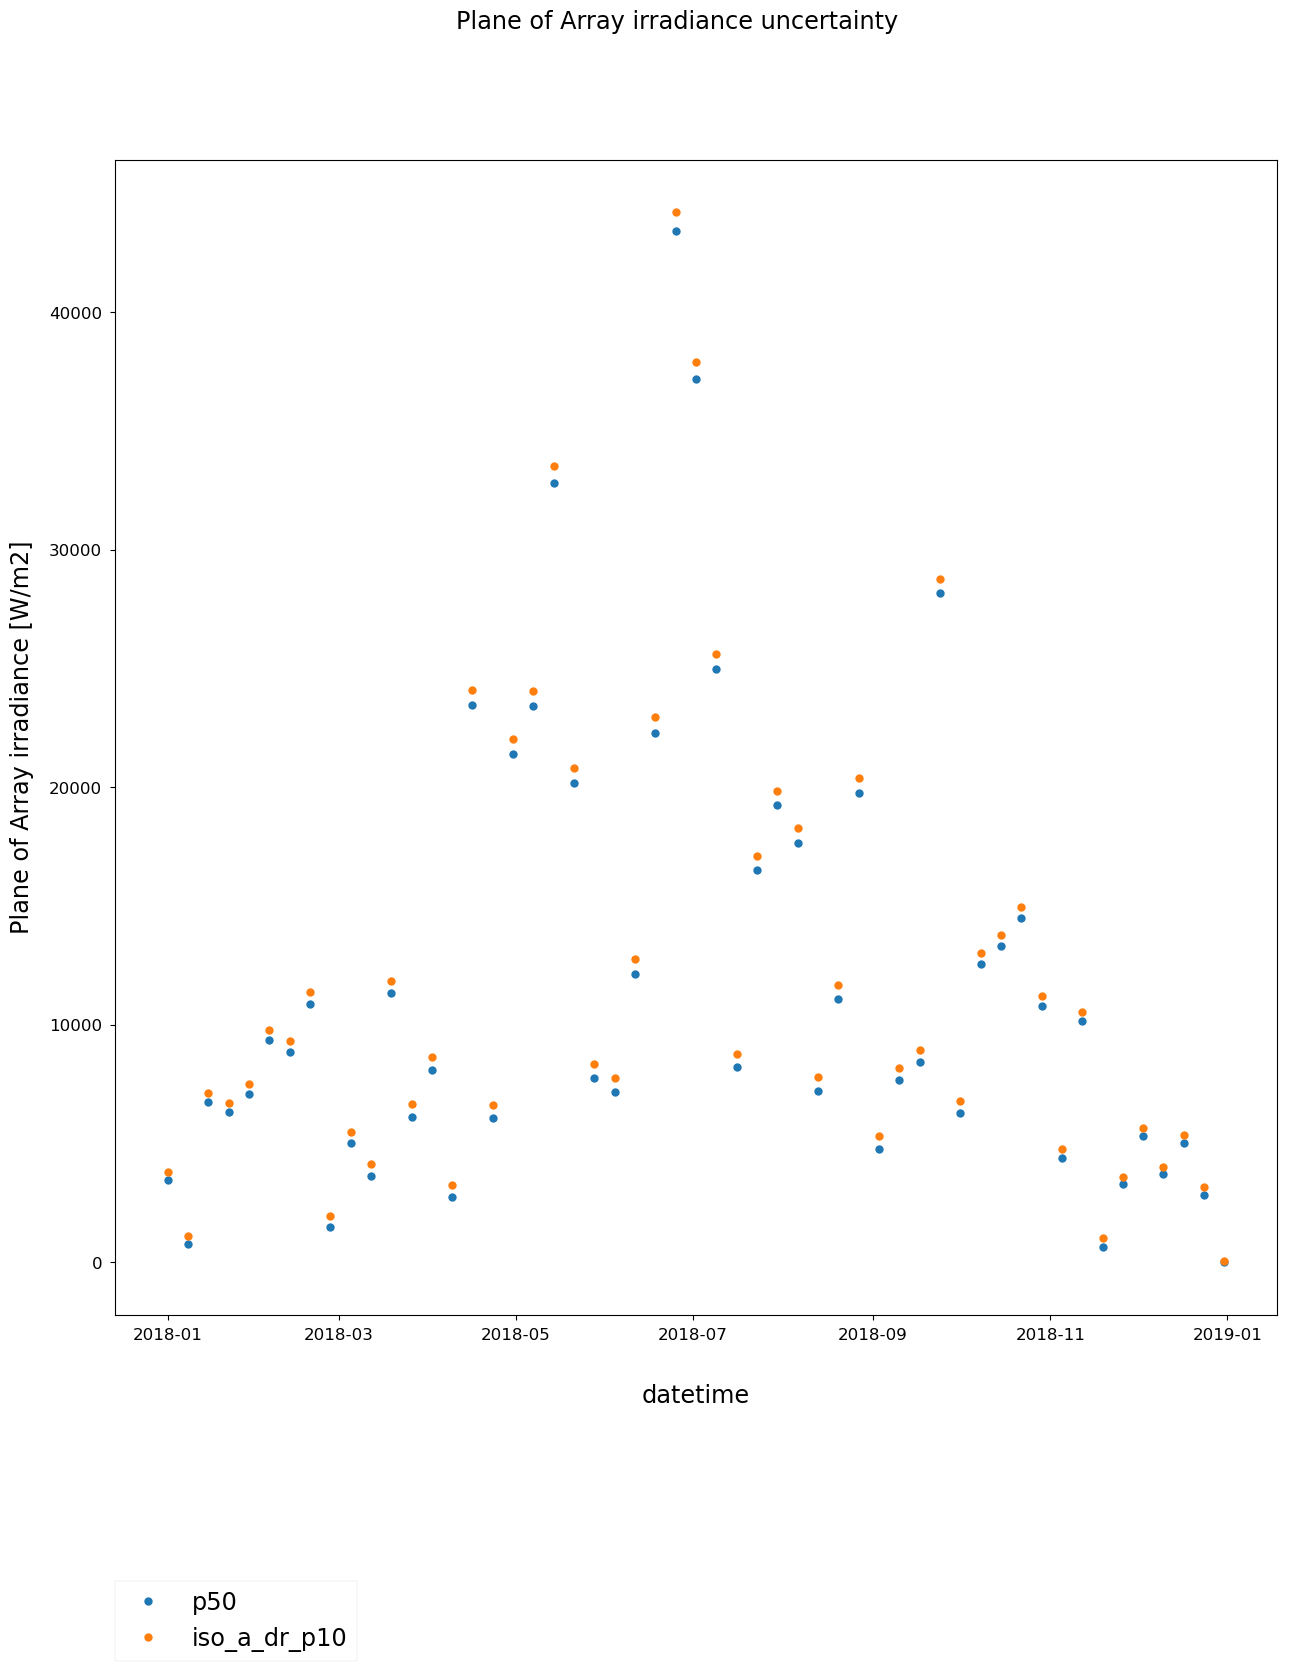

In [ ]:
if extend:    
    fig, ax = plt.subplots()
    for k, v in dfs_gum_a_dr_1h_dct.items():
        ax.plot(v.index, v["poa_direct"], markersize=6, linestyle="", marker="o")

    iplt.finalise_subplots(fig, ax, fig_title= "Plane of Array irradiance uncertainty",
                    lgn_labels = dfs_gum_a_dr_1h_dct.keys(),
                    xlabel="datetime", ylabel="Plane of Array irradiance [W/m2]", bbox_to_anchor=(0,-0.3))
        #, bbox_to_anchor=(0,-0.1)) #, loc=0)
    #, plt_prm='', bbox_to_anchor=LGN_BBOX_TO_ANCHOR, loc=LGN_LOC)

# Uncertainty model with GUM with artificial alignment

## Creating solar dataframe with different orientation and merging with original one before filtering
Using the same filtering on dfs1h on previous analysis will increase the asymmetry for the uncertainty.

In [60]:
pvmm_ma = copy.deepcopy(pvmm)
pvmm_ma.module["surface_tilt"] -= 2
pvmm_ma.module["surface_azimuth"] += 31
pvmm_ma.module["cable_azimuth"] += 31

In [37]:
dfs_ma = get_sdf(df, pvmm_ma, channel=3,
year=2018, 
month=None, #3, #None, #3, 
day=None, #13, #None, #13, 
hours=None) #[3, 13])

In [38]:
# merge files to have same valid row for irradiance
dfs_ma = dfs_ma.merge(dfs[["sapm_spectral_loss","angleofincidence"]], left_index=True, right_index=True, suffixes=["","_i"])

In [39]:
# installed
dfs_i = dfs.merge(dfs_ma[["sapm_spectral_loss","angleofincidence"]], left_index=True, right_index=True, suffixes=["","_f"])

In [40]:
dfs15m_ma = dfs_ma[
        (dfs_ma["sapm_spectral_loss"]>0) & (dfs_ma["sapm_spectral_loss"] == dfs_ma["sapm_spectral_loss"]) &
        (dfs_ma["angleofincidence"]<=80) & (dfs_ma["angleofincidence"] == dfs_ma["angleofincidence"]) &
        (dfs_ma["sapm_spectral_loss_i"]>0) & (dfs_ma["sapm_spectral_loss_i"] == dfs_ma["sapm_spectral_loss_i"]) &
        (dfs_ma["angleofincidence_i"]<=80) & (dfs_ma["angleofincidence_i"] == dfs_ma["angleofincidence_i"])     
        ].groupby(pd.Grouper(freq='60min')).agg(np.mean)
dfs15m_ma["minute_trunc"] = dfs15m_ma.index
dfs15m_ma.dropna(subset=['pyr_azimuth','angleofincidence'], inplace=True)  

C:\Users\wsfm\AppData\Local\Temp\ipykernel_22516\2584912770.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ].groupby(pd.Grouper(freq='60min')).agg(np.mean)


In [41]:
dfs15m_i = dfs_i[
        (dfs_i["sapm_spectral_loss"]!=0) & (dfs_i["sapm_spectral_loss"]==dfs_i["sapm_spectral_loss"]) &
        (dfs_i["angleofincidence"]<=80) & (dfs_i["angleofincidence"]==dfs_i["angleofincidence"]) &
        (dfs_i["sapm_spectral_loss_f"]!=0) & (dfs_i["sapm_spectral_loss_f"]==dfs_i["sapm_spectral_loss_f"]) &
        (dfs_i["angleofincidence_f"]<=80) & (dfs_i["angleofincidence_f"]==dfs_i["angleofincidence_f"])        
        ].groupby(pd.Grouper(freq='60min')).agg(np.mean)
dfs15m_i["minute_trunc"] = dfs15m_i.index
dfs15m_i.dropna(subset=['pyr_azimuth','angleofincidence'], inplace=True)  

C:\Users\wsfm\AppData\Local\Temp\ipykernel_22516\623803937.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ].groupby(pd.Grouper(freq='60min')).agg(np.mean)


## Comparing aligned and misaligned for class A
results are extracted after getting a merged index

In [42]:
dfs_i_gum_a_50_15m, dfs_i_gum_a_n_15m,  dfs_i_gum_a_p_15m = get_gum_pmp(dfs=dfs15m_i, #.iloc[:24,:], 
                                                                     pvmm=pvmm, method_iso="isoa",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              alignment_unc = True, coverage_factor=1.645)

In [43]:
dfs_ma_gum_a_50_15m, dfs_ma_gum_a_n_15m,  dfs_ma_gum_a_p_15m = get_gum_pmp(dfs=dfs15m_ma, #
                                                                        pvmm=pvmm_ma, method_iso="isoa",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
             coverage_factor=1.645, alignment_unc=True)

In [44]:
# 17/9/23 keeping same index also for other ones
# not clear why df changes if filter_same_index launched again
test = False
if test:
    [dfs_i_gum_a_50_1h_i, dfs_i_gum_a_n_1h_i,  dfs_i_gum_a_p_1h_i, dfs_ma_gum_a_50_1h_i, dfs_ma_gum_a_n_1h_i,  dfs_ma_gum_a_p_1h_i], i_ma_ind= filter_same_index(
        dfs = [dfs_i_gum_a_50_1h, dfs_i_gum_a_n_1h,  dfs_i_gum_a_p_1h, dfs_ma_gum_a_50_1h, dfs_ma_gum_a_n_1h,  dfs_ma_gum_a_p_1h])

## Comparing aligned and misaligned for class B

In [45]:
dfs_i_gum_b_50_15m, dfs_i_gum_b_n_15m,  dfs_i_gum_b_p_15m = get_gum_pmp(dfs=dfs15m_i, #.iloc[:24,:], 
                                                                     pvmm=pvmm, method_iso="isob",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645, alignment_unc=True)

In [46]:
dfs_ma_gum_b_50_15m, dfs_ma_gum_b_n_15m,  dfs_ma_gum_b_p_15m = get_gum_pmp(dfs=dfs15m_ma, 
                                                                        pvmm=pvmm_ma, method_iso="isoc", #.iloc[:24,:], pvmm=pvmm_ma, method_iso="isoc",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
             coverage_factor=1.645, alignment_unc=True)

## Comparing aligned and misaligned for class a without directional response

In [65]:
dfs_i_gum_a_50_15m, dfs_i_gum_a_n_15m,  dfs_i_gum_a_p_15m = get_gum_pmp(dfs=dfs15m_i, #.iloc[:24,:], 
                                                                              pvmm=pvmm, method_iso="isoa",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645, alignment_unc=True)

In [66]:
dfs_ma_gum_a_50_15m, dfs_ma_gum_a_n_15m,  dfs_ma_gum_a_p_15m = get_gum_pmp(dfs=dfs15m_ma, #.iloc[:24,:], 
                                                                                 pvmm=pvmm_ma, method_iso="isoa",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
             coverage_factor=1.645, alignment_unc=True)

## Comparing aligned and misaligned for class a with directional response

In [47]:
dfs_i_gum_a_dr_50_15m, dfs_i_gum_a_dr_n_15m,  dfs_i_gum_a_dr_p_15m = get_gum_pmp(dfs=dfs15m_i, #.iloc[:24,:], 
                                                                              pvmm=pvmm, method_iso="isoa",  
              directional_error=True, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645, alignment_unc=True)

In [48]:
dfs_ma_gum_a_dr_50_15m, dfs_ma_gum_a_dr_n_15m,  dfs_ma_gum_a_dr_p_15m = get_gum_pmp(dfs=dfs15m_ma, #.iloc[:24,:], 
                                                                                 pvmm=pvmm_ma, method_iso="isoa",  
              directional_error=True, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
             coverage_factor=1.645, alignment_unc=True)

## Comparing aligned and misaligned for class C with directional response
not necessary dr for c

In [63]:

dfs_i_gum_c_50_15m, dfs_i_gum_c_n_15m,  dfs_i_gum_c_p_15m = get_gum_pmp(dfs=dfs15m_i, #.iloc[:24,:], 
                                                                              pvmm=pvmm, method_iso="isoc",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
              coverage_factor=1.645, alignment_unc=True)

In [64]:
dfs_ma_gum_c_50_15m, dfs_ma_gum_c_n_15m,  dfs_ma_gum_c_p_15m = get_gum_pmp(dfs=dfs15m_ma, #.iloc[:24,:], 
                                                                                 pvmm=pvmm_ma, method_iso="isoc",  
              directional_error=False, temp_calc=False,
              effective_irradiance="effective_irradiance", decimals=3,
             coverage_factor=1.645, alignment_unc=True)

NEED TO CHECK IF ALIGNMENT CORRECT

In [67]:
dfs_lst_15m_i_ma=[
dfs_i_gum_a_dr_50_15m, dfs_i_gum_a_dr_n_15m,  dfs_i_gum_a_dr_p_15m,
dfs_ma_gum_a_dr_50_15m, dfs_ma_gum_a_dr_n_15m,  dfs_ma_gum_a_dr_p_15m,
dfs_i_gum_a_50_15m, dfs_i_gum_a_n_15m,  dfs_i_gum_a_p_15m,
dfs_ma_gum_a_50_15m, dfs_ma_gum_a_n_15m,  dfs_ma_gum_a_p_15m,
dfs_i_gum_b_50_15m, dfs_i_gum_b_n_15m,  dfs_i_gum_b_p_15m,
dfs_ma_gum_b_50_15m, dfs_ma_gum_b_n_15m,  dfs_ma_gum_b_p_15m,
dfs_i_gum_c_50_15m, dfs_i_gum_c_n_15m,  dfs_i_gum_c_p_15m,
dfs_ma_gum_c_50_15m, dfs_ma_gum_c_n_15m,  dfs_ma_gum_c_p_15m
]

In [68]:
dfs_lst_15m_i_ma_int = get_dfs_r(dfs_lst_15m_i_ma)

## Comparing results after merging the datetime indexes

In [69]:
rlss_prn = []
rlss_dfs = []
for i in range(0,8):
    rlss_prn_tmp, rlss_dfs_tmp = get_uncertainties_results(pvmm=pvmm if 0 % 2 == 0 else pvmm_ma,
        dfs_50 = dfs_lst_15m_i_ma_int[i*3], dfs_n = dfs_lst_15m_i_ma_int[i*3+1], dfs_p = dfs_lst_15m_i_ma_int[i*3+2], step_m=15                                             
    )
    rlss_prn.append(rlss_prn_tmp)
    rlss_dfs.append(rlss_dfs_tmp)
    print(rlss_prn_tmp)

{'poa kWh': 299, 'poa10 kWh': 290, 'poa90 kWh': 309, 'poa_0_10 kWh': 299, 'poa_0_90 kWh': 299, 'mp0 MWh': 238, 'mp50 MWh': 382, 'mp10 MWh': 370, 'mp90 MWh': 395, 'poa10 %': -3.01, 'poa90 %': 3.34, 'mp10 %': -3.14, 'mp90 %': 3.4}
{'poa kWh': 299, 'poa10 kWh': 290, 'poa90 kWh': 309, 'poa_0_10 kWh': 299, 'poa_0_90 kWh': 299, 'mp0 MWh': 238, 'mp50 MWh': 375, 'mp10 MWh': 363, 'mp90 MWh': 387, 'poa10 %': -3.01, 'poa90 %': 3.34, 'mp10 %': -3.2, 'mp90 %': 3.2}
{'poa kWh': 299, 'poa10 kWh': 287, 'poa90 kWh': 311, 'poa_0_10 kWh': 299, 'poa_0_90 kWh': 299, 'mp0 MWh': 238, 'mp50 MWh': 382, 'mp10 MWh': 368, 'mp90 MWh': 397, 'poa10 %': -4.01, 'poa90 %': 4.01, 'mp10 %': -3.66, 'mp90 %': 3.93}
{'poa kWh': 299, 'poa10 kWh': 287, 'poa90 kWh': 311, 'poa_0_10 kWh': 299, 'poa_0_90 kWh': 299, 'mp0 MWh': 238, 'mp50 MWh': 375, 'mp10 MWh': 361, 'mp90 MWh': 390, 'poa10 %': -4.01, 'poa90 %': 4.01, 'mp10 %': -3.73, 'mp90 %': 4.0}
{'poa kWh': 299, 'poa10 kWh': 275, 'poa90 kWh': 323, 'poa_0_10 kWh': 299, 'poa_0_90 

In [70]:
for i in range(0,8):
    print(rlss_dfs[0].sum())

g_cmp11_ppuk_avg          1.196160e+06
g_cmp11_ppuk_avg_0        1.196160e+06
pmpp                      2.649142e+05
p_mp                      4.248778e+05
g_cmp11_ppuk_avg_p10      1.158244e+06
p_mp_p10                  4.108612e+05
g_cmp11_ppuk_avg_0_p10    1.196160e+06
g_cmp11_ppuk_avg_p90      1.234090e+06
p_mp_p90                  4.388745e+05
g_cmp11_ppuk_avg_0_p90    1.196160e+06
dtype: float64
g_cmp11_ppuk_avg          1.196160e+06
g_cmp11_ppuk_avg_0        1.196160e+06
pmpp                      2.649142e+05
p_mp                      4.248778e+05
g_cmp11_ppuk_avg_p10      1.158244e+06
p_mp_p10                  4.108612e+05
g_cmp11_ppuk_avg_0_p10    1.196160e+06
g_cmp11_ppuk_avg_p90      1.234090e+06
p_mp_p90                  4.388745e+05
g_cmp11_ppuk_avg_0_p90    1.196160e+06
dtype: float64
g_cmp11_ppuk_avg          1.196160e+06
g_cmp11_ppuk_avg_0        1.196160e+06
pmpp                      2.649142e+05
p_mp                      4.248778e+05
g_cmp11_ppuk_avg_p10      1.158244

# Long-term Energy Production Uncertainty



## Importing different years


In [ ]:
DATA_FOLDERPATH = r"C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model\data"
f = "_select_m1_year_trunc_m1_g_cmp11_ppuk_sum_m1_g_cmp11_ppuk_count__202308250448.csv"
datetime_column = "year_trunc"
datetime_format=r"%Y-%m-%d %H:%M:%S"
channelnumber = 3

folderpath = os.path.join(DATA_FOLDERPATH,datetime_column)

filepath = os.path.join(folderpath,f)

df1y = pd.read_csv(filepath_or_buffer=filepath,encoding="utf-8-sig",delimiter=",", encoding_errors="replace")

df1y[datetime_column] = df1y[datetime_column].apply(lambda x: pd.to_datetime(x, format=datetime_format, utc=False))

df1y.index = pd.DatetimeIndex(df1y[datetime_column], ambiguous='NaT', name="datetime")

df1y.sort_values(by="datetime", inplace=True)

In [ ]:
df1y.columns

Index(['year_trunc', 'g_cmp11_ppuk_sum', 'g_cmp11_ppuk_count', 'channelnumber',
       'pmpp_sum', 'pmpp_count'],
      dtype='object')

In [ ]:
# 3 years only, skipping calculated variability
df1y.loc[df1y["channelnumber"]==channelnumber,'g_cmp11_ppuk_sum']

datetime
2013-01-01    1.626777e+09
2014-01-01    1.968456e+09
2015-01-01    3.271140e+09
2016-01-01    3.994747e+09
2017-01-01    4.112667e+09
2018-01-01    4.496269e+09
2019-01-01    4.477050e+09
2020-01-01    4.522217e+09
Name: g_cmp11_ppuk_sum, dtype: float64

In [ ]:
np.std(df1y.loc[df1y["channelnumber"]==channelnumber,'g_cmp11_ppuk_sum'][-5:])/(5**0.5)/(df1y.loc[df1y["channelnumber"]==channelnumber,'g_cmp11_ppuk_sum'][-5:].sum()/5)

0.022931138302473956

In [ ]:
# irradiance on module
h_poa_2018_kWh = df1y.loc[df1y["channelnumber"]==3].loc["2018-01-01",'g_cmp11_ppuk_sum']/60/1000
#module["Length"]*module["Width"]
h_poa_2018_kWh

74937.81518815

## Long-term uncertainty

In [ ]:
yield_uncertainty = unc.Irradiance_Uncertainty(sensitivity=None)

In [ ]:
coverage_factor = 1.645
sr_a_dr = abs (-4.8 / coverage_factor)
sr_a = abs (-5.25 / coverage_factor)
sr_c = abs (-17.16/ coverage_factor)
channel_number  = 3
year = 2016
years = [2016, 2017, 2018, 2019, 2020]

In [ ]:
# 25/8/23 20 years of data
INSOLATION_VARIABILITY_5Y={'uncertainty':'insolation_variability','parameter':'irradiance','distribution':'normal',
                           'shape':'symmetric','divisor':1,'unit':'%','acceptance':3.31}
#19/9/21 Solar resource calculated for the first year
# calculated for the entire period although maybe average could be considered
SOLAR_RESOURCE_AOI= {'uncertainty':'solar_resource_aoi','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                         'acceptance': sr_a_dr}

SOLAR_RESOURCE = {'uncertainty':'solar_resource','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance': sr_c}

In [ ]:

#for testing purpose using irradiance as parameter for all instead of irradiance 

# TRANSPOSITION MODEL NOT NEEDED
# Notes: it is true that long-term simulation are done with gpoa but nothing prevent to do them with POA actually

# AMBIENT_TEMPERATURE_VARIABILITY_5Y could be estimated from CREST available data

#best fitting 0.14, exemplary simulation 1, bad fitting 1;15
TEMPERATURE_EFFECT =  {'uncertainty':'temperature_effect','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':1}

# negative only, period to be checked. lowest value in accord with Nikol's thesis
# long-term not included in one year
PERFORMANCE_LOSS = {'uncertainty':'performance_loss','parameter':'irradiance','distribution':'normal',
                     'shape':'negative','divisor':1,'unit':'%',
                     'acceptance':0.5}

# low uncertainty minor issue in Lboro and experimental research system
SOILING = {'uncertainty':'soiling','parameter':'irradiance','distribution':'normal',
                     'shape':'negative','divisor':1,'unit':'%',
                     'acceptance':0.5}

# SHADING EFFECT not considered

REFLECTION_MISMATCH = {'uncertainty':'reflection_mismatch','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':3}

NOMINAL_POWER = {'uncertainty':'nominal_irradiance','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':2} #0.98}

INVERTER_EFFICIENCY = {'uncertainty':'inverter_efficiency','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':2} #0.2}

# DC cabling not considered
# Power limitation not considered
# Transformer not considered
# System behaviour 

In [ ]:
yield_df = pd.DataFrame()

yield_uncertainties_df = pd.DataFrame()

yield_uncertainties = [SOLAR_RESOURCE_AOI, SOLAR_RESOURCE, TEMPERATURE_EFFECT,
                     PERFORMANCE_LOSS, SOILING, REFLECTION_MISMATCH, NOMINAL_POWER, INVERTER_EFFICIENCY]

for value in list(yield_uncertainties ):
    yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
#DEV NOTE 26/9/21 index not column used for uncertainty type
yield_uncertainties_df.index = yield_uncertainties_df.loc[:,"uncertainty"]

#showing uncertainty_df
# 6/11/21 only irradiance-dependant uncertainty provided
yield_uncertainties_df

C:\Users\wsfm\AppData\Local\Temp\ipykernel_9800\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_9800\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_9800\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_9800\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

,uncertainty,parameter,distribution,shape,divisor,unit,acceptance
uncertainty,,,,,,,
solar_resource_aoi,solar_resource_aoi,irradiance,normal,symmetric,1,%,2.917933
solar_resource,solar_resource,irradiance,normal,symmetric,1,%,10.431611
temperature_effect,temperature_effect,irradiance,normal,symmetric,1,%,1.000000
performance_loss,performance_loss,irradiance,normal,negative,1,%,0.500000
soiling,soiling,irradiance,normal,negative,1,%,0.500000
reflection_mismatch,reflection_mismatch,irradiance,normal,symmetric,1,%,3.000000
nominal_irradiance,nominal_irradiance,irradiance,normal,symmetric,1,%,2.000000
inverter_efficiency,inverter_efficiency,irradiance,normal,symmetric,1,%,2.000000


In [ ]:
yield_uncertainty.uncertainties_df = yield_uncertainties_df

yield_uncertainty_labels_y1 = yield_uncertainties_df.uncertainty.to_list()
yield_uncertainty_labels_y1.remove("solar_resource_aoi")
yield_uncertainty_labels_y1.remove("performance_loss")

yield_uncertainty_labels_y1_aoi = yield_uncertainties_df.uncertainty.to_list()
yield_uncertainty_labels_y1_aoi.remove("solar_resource")
yield_uncertainty_labels_y1_aoi.remove("performance_loss")

## Simulation with class c

In [ ]:
randomstate = np.random.RandomState(210829)
percentiles = [10, 50, 90]

simulations = 1000
#mc not needed for calibration uncertainty since function and cofficients known

irradiance = pd.Series(h_poa_2018_kWh)

deviations_mc_y1 = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=yield_uncertainty_labels_y1,
                                                                  angle_of_incidence=None)


deviations_mc_y1

Empty DataFrame
Columns: [10, 50, 90]
Index: []


,10,50,90
0,-11188.336414,174.90748,11105.646977


In [ ]:
years_n = len(years)
ylabels = ["p10","p50","p90"]
pv_yield_y1 = irradiance.values[0]

pv_yield = pd.DataFrame()
pv_yield["year"] = years #pvs_slc["year"].unique()
pv_yield.set_index(keys="year", drop=True, inplace=True)
# DEV NOTE 26/9/21 formatting of p100 could be done

devs_y1 = {}

l = "dev_y1_"
for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
    pv_yield[l+k] = [deviations_mc_y1.loc[:,v][0]] * years_n
    devs_y1[k]=l+k
    #pv_yield[k] = 1 + pv_yield[l+k] / pv_yield_y1
    #pv_yield[k] = [1 + deviations_mc_y1.loc[:,v][0] / pv_yield_y1 ] * years
pv_yield

,dev_y1_p10,dev_y1_p50,dev_y1_p90
year,,,
2016,-11188.336414,174.90748,11105.646977
2017,-11188.336414,174.90748,11105.646977
2018,-11188.336414,174.90748,11105.646977
2019,-11188.336414,174.90748,11105.646977
2020,-11188.336414,174.90748,11105.646977


In [ ]:
#long-term deviations
l = "dev_lt_"
# assing deviation first year to all years. Long-term deviation will be cumulated after
pv_yield[[l+p for p in ylabels]] = pv_yield[["dev_y1_"+p for p in ylabels]]
for y in pv_yield.index.to_list():
    deviations_mc_lt = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=["performance_loss"],
                                                                  angle_of_incidence=None)
    for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
        # adding long-term deviation. Small contribution comparing to existing one.
        pv_yield.loc[pv_yield.index >= y,l+k] += deviations_mc_lt.loc[:,v][0]

pv_yield

Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []


,dev_y1_p10,dev_y1_p50,dev_y1_p90,dev_lt_p10,dev_lt_p50,dev_lt_p90
year,,,,,,
2016,-11188.336414,174.90748,11105.646977,-11646.843436,173.408724,11572.809317
2017,-11188.336414,174.90748,11105.646977,-12121.949185,181.089850,12046.828467
2018,-11188.336414,174.90748,11105.646977,-12609.044983,162.542741,12507.733499
2019,-11188.336414,174.90748,11105.646977,-13076.282261,185.586119,13000.861792
2020,-11188.336414,174.90748,11105.646977,-13521.075663,182.401262,13482.412192


Legend: loc (0, 0), bbox_to_anchor (0, -0.2)
Final yield uncertainty long-term.jpg saved at c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model/outputs/figures/


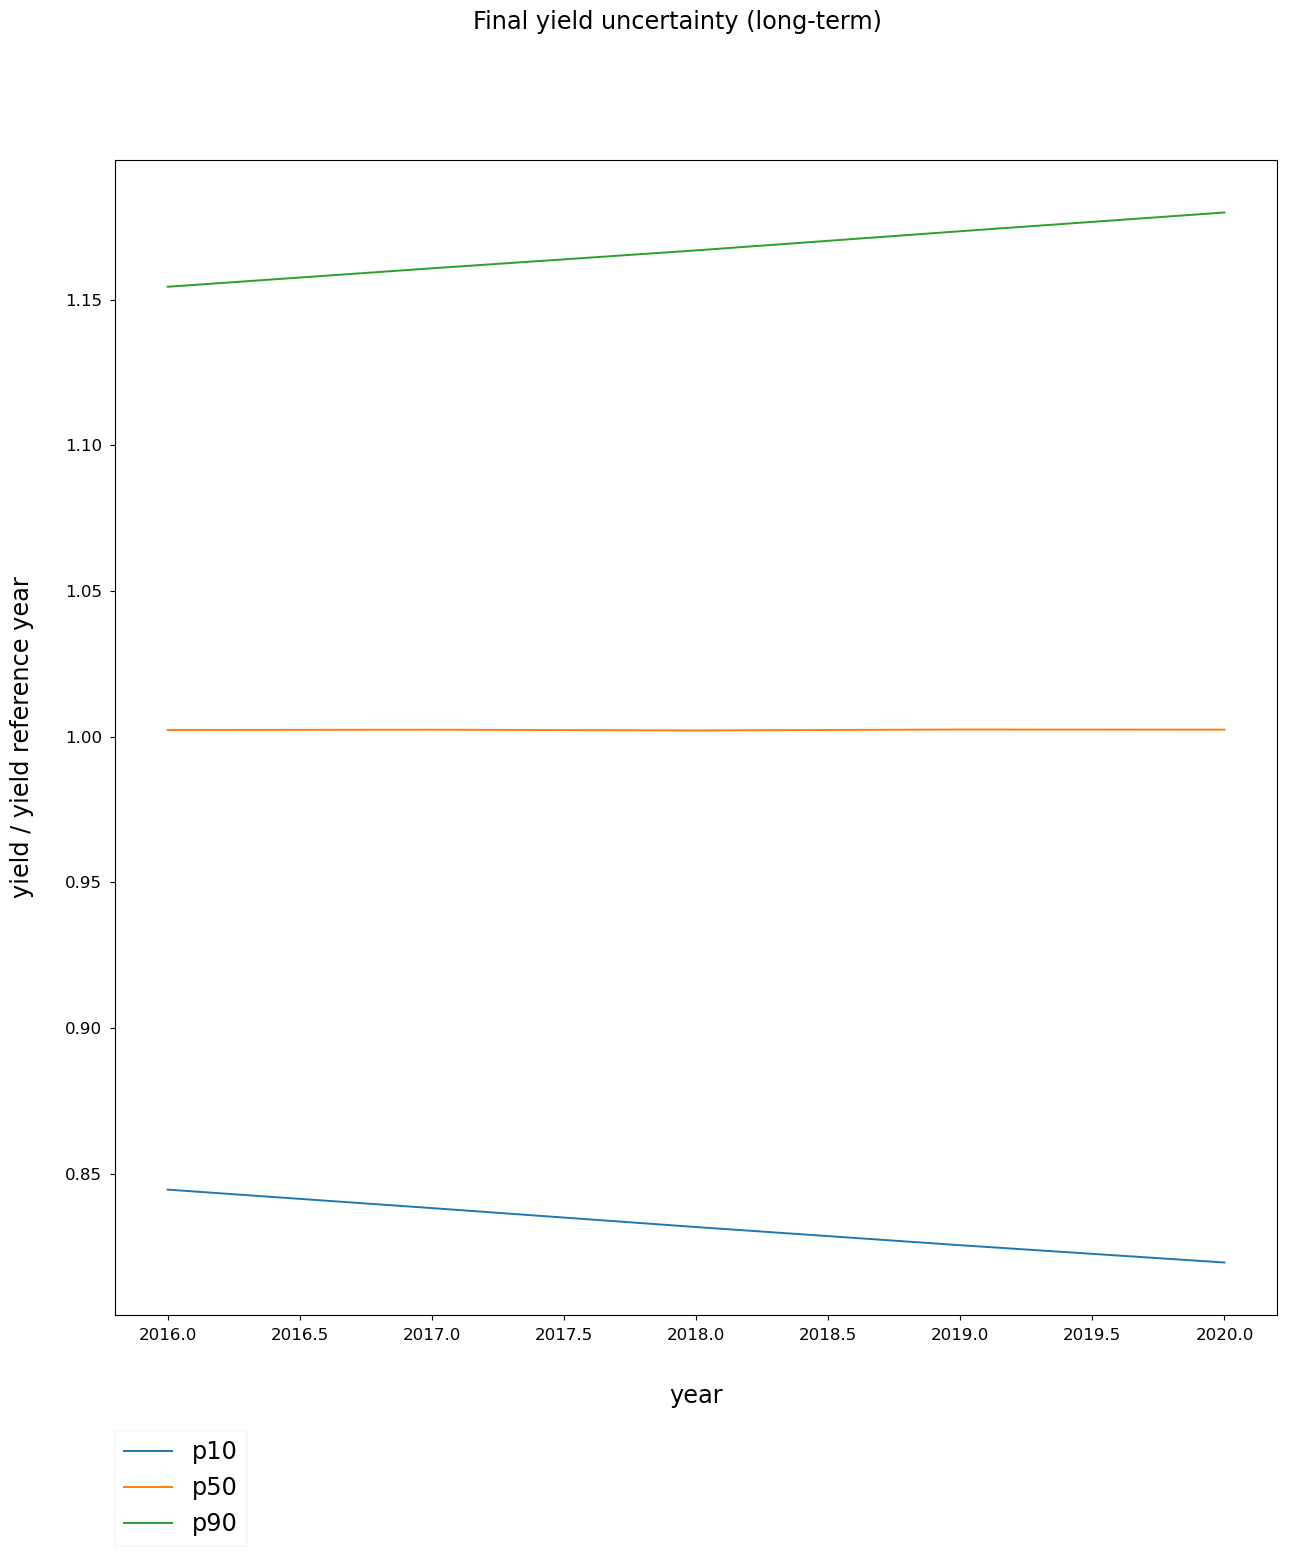

In [ ]:
fig, ax = plt.subplots()
for c in [c for c in pv_yield.columns.to_list() if l in c]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield.index, 1 + pv_yield.loc[:,c] / pv_yield_y1)

iplt.finalise_subplots(fig, ax, fig_title= "Final yield uncertainty (long-term)",
                  lgn_labels = ylabels,
                       xlabel="year", ylabel="yield / yield reference year", bbox_to_anchor=(0,-0.2))


## Simulation with directional error

In [ ]:
randomstate = np.random.RandomState(210830)
percentiles = [10, 50, 90]

simulations = 1000
#mc not needed for calibration uncertainty since function and cofficients known

irradiance = pd.Series(h_poa_2018_kWh)

deviations_mc_y1_aoi = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=yield_uncertainty_labels_y1_aoi,
                                                                  angle_of_incidence=None)


deviations_mc_y1_aoi

Empty DataFrame
Columns: [10, 50, 90]
Index: []


,10,50,90
0,-10886.349433,-367.800605,10652.265109


In [ ]:
years_n = len(years)
ylabels = ["p10","p50","p90"]
pv_yield_y1_aoi = irradiance.values[0]

pv_yield_aoi = pd.DataFrame()
pv_yield_aoi["year"] = years #pvs_slc["year"].unique()
pv_yield_aoi.set_index(keys="year", drop=True, inplace=True)
# DEV NOTE 26/9/21 formatting of p100 could be done

devs_y1_aoi = {}

l = "dev_y1_"
for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
    pv_yield_aoi[l+k] = [deviations_mc_y1_aoi.loc[:,v][0]] * years_n
    devs_y1_aoi[k]=l+k
    #pv_yield[k] = 1 + pv_yield[l+k] / pv_yield_y1
    #pv_yield[k] = [1 + deviations_mc_y1.loc[:,v][0] / pv_yield_y1 ] * years
pv_yield_aoi

,dev_y1_p10,dev_y1_p50,dev_y1_p90
year,,,
2016,-10886.349433,-367.800605,10652.265109
2017,-10886.349433,-367.800605,10652.265109
2018,-10886.349433,-367.800605,10652.265109
2019,-10886.349433,-367.800605,10652.265109
2020,-10886.349433,-367.800605,10652.265109


In [ ]:
#long-term deviations
l = "dev_lt_"
# assing deviation first year to all years. Long-term deviation will be cumulated after
pv_yield_aoi[[l+p for p in ylabels]] = pv_yield_aoi[["dev_y1_"+p for p in ylabels]]
for y in pv_yield_aoi.index.to_list():
    deviations_mc_lt_aoi = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=["performance_loss"],
                                                                  angle_of_incidence=None)
    for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
        # adding long-term deviation. Small contribution comparing to existing one.
        pv_yield_aoi.loc[pv_yield_aoi.index >= y,l+k] += deviations_mc_lt_aoi.loc[:,v][0]

pv_yield_aoi

Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []
Empty DataFrame
Columns: [10, 50, 90]
Index: []


,dev_y1_p10,dev_y1_p50,dev_y1_p90,dev_lt_p10,dev_lt_p50,dev_lt_p90
year,,,,,,
2016,-10886.349433,-367.800605,10652.265109,-11365.351947,-380.352689,11122.050272
2017,-10886.349433,-367.800605,10652.265109,-11819.550045,-397.963076,11619.899647
2018,-10886.349433,-367.800605,10652.265109,-12297.016335,-397.401042,12116.362673
2019,-10886.349433,-367.800605,10652.265109,-12770.660796,-387.097093,12609.565904
2020,-10886.349433,-367.800605,10652.265109,-13263.901495,-401.709967,13063.764002


Legend: loc (0, 0), bbox_to_anchor (0, -0.2)
Final yield uncertainty long-term.jpg saved at c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model/outputs/figures/


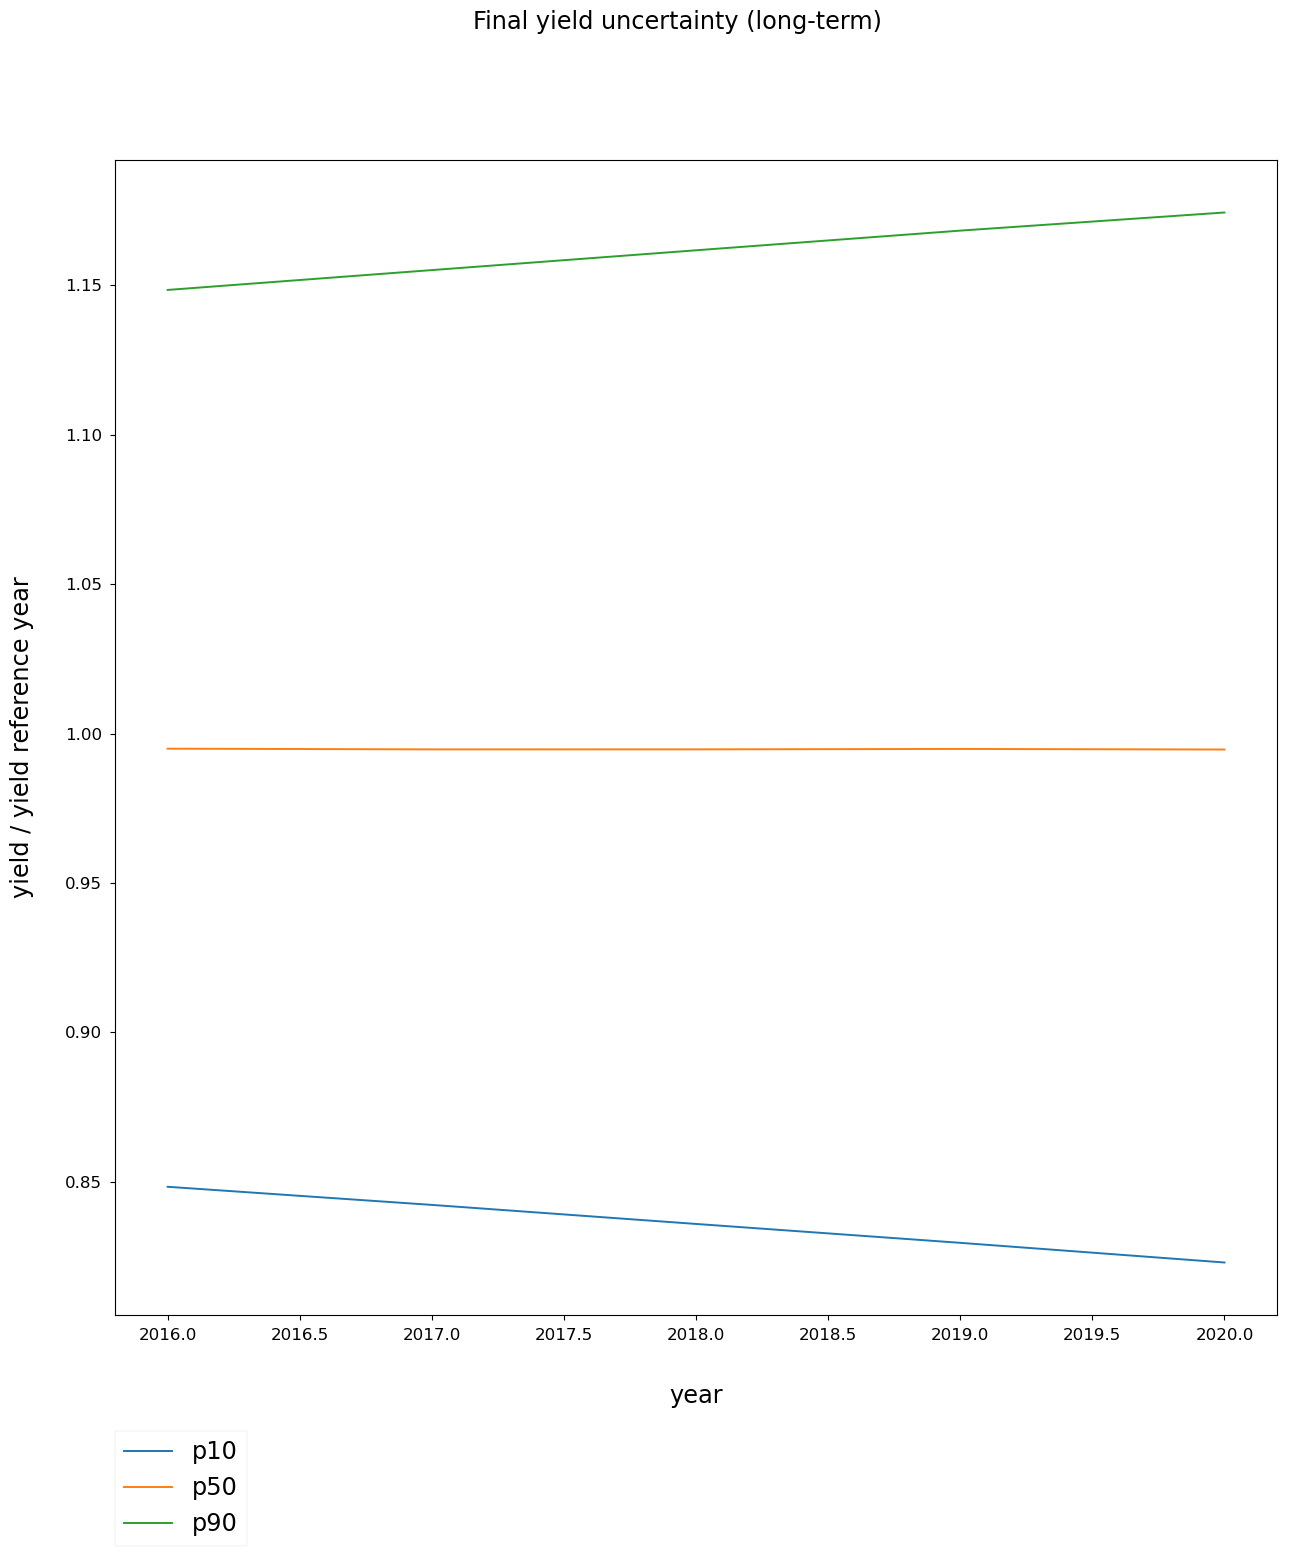

In [ ]:
fig, ax = plt.subplots()
for c in [c for c in pv_yield_aoi.columns.to_list() if l in c]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield_aoi.index, 1 + pv_yield_aoi.loc[:,c] / pv_yield_y1_aoi)

iplt.finalise_subplots(fig, ax, fig_title= "Final yield uncertainty (long-term)",
                  lgn_labels = ylabels,
                       xlabel="year", ylabel="yield / yield reference year", bbox_to_anchor=(0,-0.2))


## Plot together class C and class A

In [ ]:
pv_yield_aoi.columns.to_list()

['dev_y1_p10',
 'dev_y1_p50',
 'dev_y1_p90',
 'dev_lt_p10',
 'dev_lt_p50',
 'dev_lt_p90']

Legend: loc (0, 0), bbox_to_anchor (0, -0.2)
Final yield uncertainty long-term.jpg saved at c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model/outputs/figures/


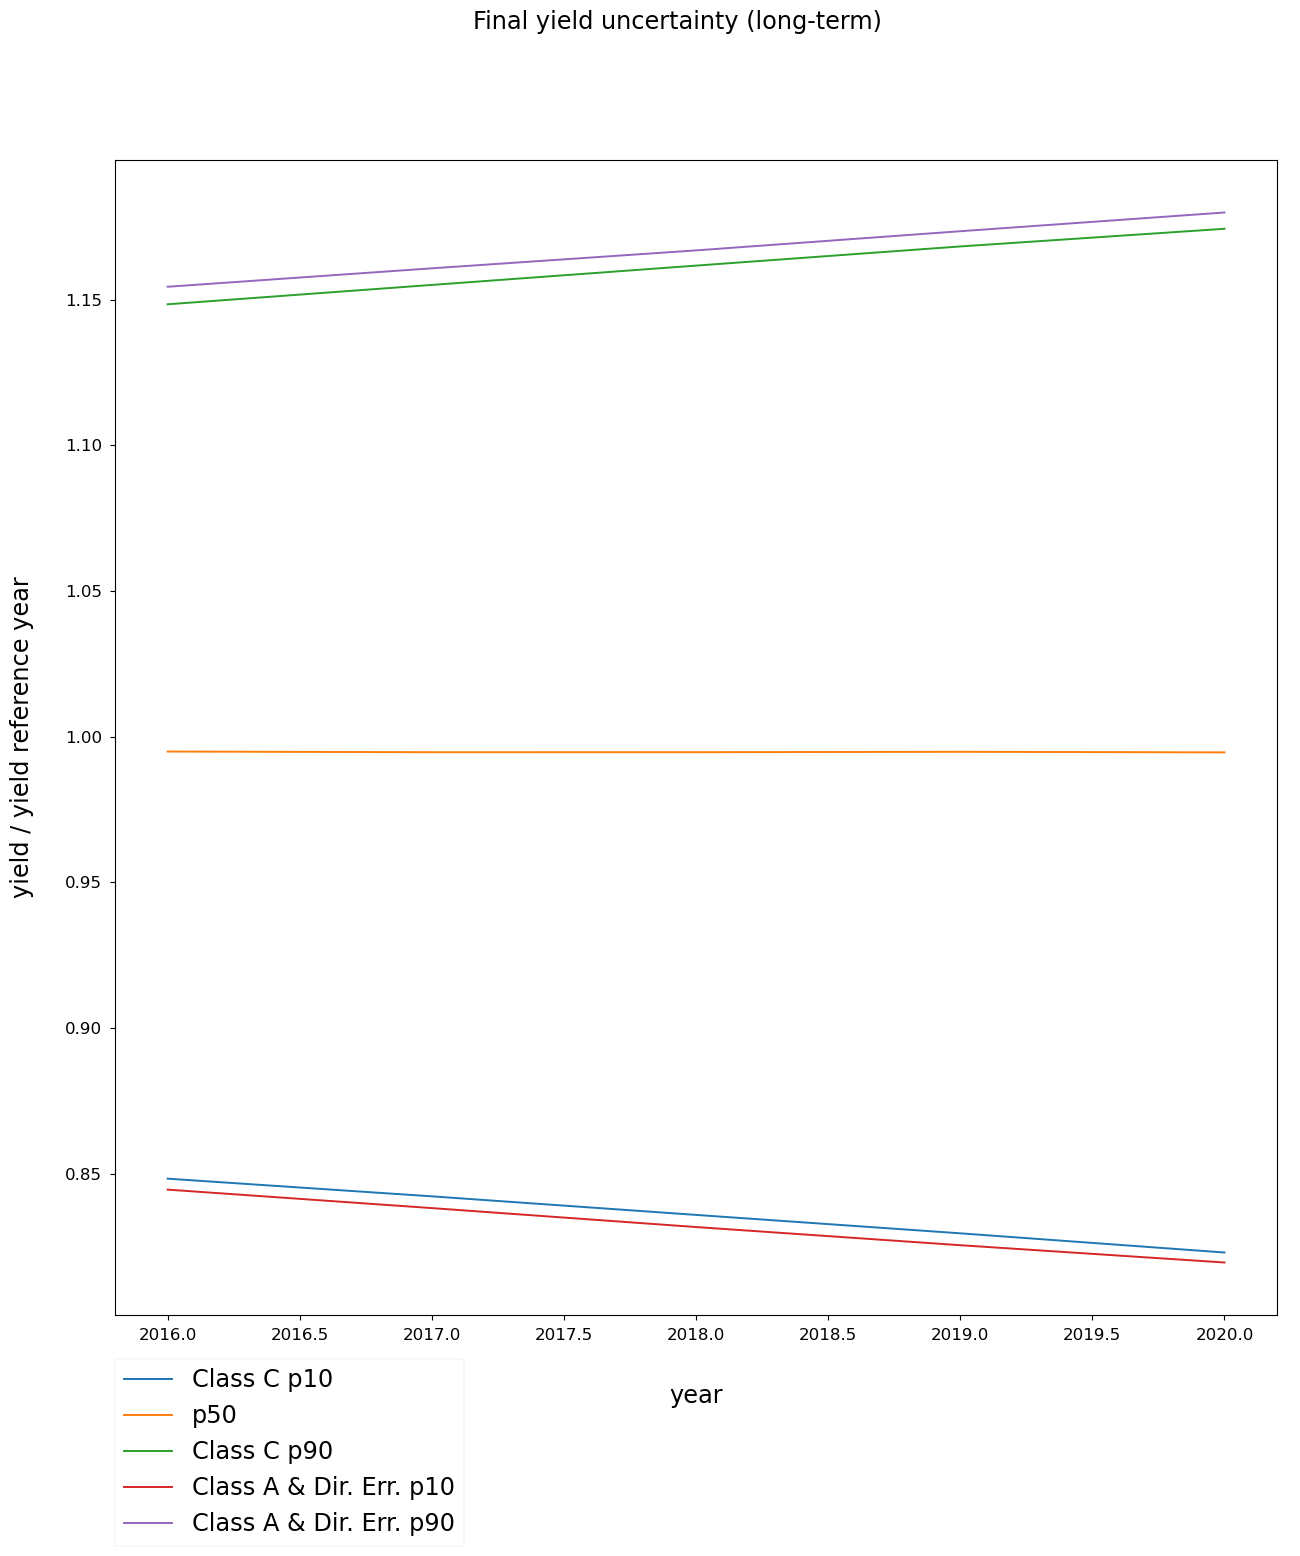

In [ ]:
fig, ax = plt.subplots()

ylabels = ["Class C p10","p50","Class C p90", "Class A & Dir. Err. p10", "Class A & Dir. Err. p90"]

for c in [c for c in pv_yield_aoi.columns.to_list() if l in c]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield_aoi.index, 1 + pv_yield_aoi.loc[:,c] / pv_yield_y1_aoi)

for c in [c for c in pv_yield_aoi.columns.to_list() if l in c and c != "dev_lt_p50"]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield.index, 1 + pv_yield.loc[:,c] / pv_yield_y1)


iplt.finalise_subplots(fig, ax, fig_title= "Final yield uncertainty (long-term)",
                  lgn_labels = ylabels,
                       xlabel="year", ylabel="yield / yield reference year", bbox_to_anchor=(0,-0.2))


# Annex Testing modeling

In [ ]:
# define module to get latitude
pvmm = pvlwu.pv_module_model(module, sapm_module, pld=PLD_CREST)

In [ ]:
# explicit only the ones already defined
# if needed check in csky which global values are used for the specific functions
sl_r = SolarLibrary(latitude=pvmm.module["latitude"], longitude=pvmm.module["longitude"], 
                 altitude=pvmm.module["altitude"], surface_zenith=pvmm.module["surface_tilt"], 
                 surface_azimuth=pvmm.module["surface_azimuth"], #package=PACKAGE,
                 apparent_zenith_model=pvmm.methods["relative_airmass"],
                 # poa_model=POA_MODEL, 
                 # transmittance=TRANSMITTANCE, # for liu-jordan, not needed
                 pressure=pvmm.pressure,
                 # albedo=ALBEDO, # ground_diffuse, not needed
                 # diffuse_model=DIFFUSE_MODEL, # perez, not needed
                 # timezone=TIMEZONE, #for sun path not needed 
                 # temperature=TEMPERATURE,  #for sun position not needed
                 delta_t=pvmm.delta_t, atmos_refract=pvmm.atmos_refract, solar_constant=pvmm.solar_constant,
                 extraradiation_method = pvmm.methods["extraradiation"], 
                 epoch_year=pvmm.epoch_year,
                 #clear_sky_model = CLEAR_SKY_MODEL, #csky not needed
                 numthreads = pvmm.numthreads)

In [ ]:
sdf = sl_r.getsolardataframe(df11s.index, outputs=["zenith", "azimuth", "angleofincidence",
"airmassabsolute"])

In [ ]:
# not clear why needed columns selection
df11s = df11s.merge(sdf[[c for c in ["zenith","azimuth", "angleofincidence","airmassabsolute"] if 
c not in df11s.columns]], left_index=True, right_index=True)

In [ ]:
df11s.columns

Index(['hour_trunc', 'g_cmp11_ppuk_avg', 't_ambient_avg', 'wind_speed_avg',
       'chp_02_avg', 'chp_02_pt100_avg', 'impp_avg', 'vmpp_avg',
       'temp_module1_avg', 'zenith', 'azimuth', 'angleofincidence',
       'airmassabsolute', 'pyr_azimuth'],
      dtype='object')

In [ ]:
sensor_uncertainty = unc.Irradiance_Uncertainty( method="isoa cmp11",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY)

In [ ]:
#uncertainties to be considered both for gum (and mc)
uncertainties_labels = sensor_uncertainty.uncertainties_df.index.to_list()
# remove zero_offset_total since using its single components
uncertainties_labels.remove("zero_offset_total")
# remove alignement error since using systematical functional dependency
# 23/8/12 remove it since not implemented yet ?
uncertainties_labels.remove("alignment_zenith")
uncertainties_labels.remove("alignment_azimuth")
# 23/7/23 not removing alignment since rather directional response with functional dependency
# 23/8/11 keeping tilt_response and directional response
# uncertainties_labels.remove("tilt_response")
# uncertainties_labels.remove("directional_response")

uncs_no_mc = dict(zip(uncertainties_labels,[None]*len(uncertainties_labels )))
print(", ".join(uncs_no_mc.keys()))
#sensor_uncertainty.uncertainties_df

zero_offset_a, zero_offset_b, zero_offset_other, non_stability, non_linearity, directional_response, spectral_error, temperature_response, tilt_response, signal_processing, calibration, maintenance


In [ ]:
df11s["pyr_azimuth"] = df11s["azimuth"].apply(lambda x: (x+CABLE_AZIMUTH ) % 360)

In [ ]:
# replace aoi > 90 with 90
df11s["angleofincidence"]=df11s["angleofincidence"].apply(lambda x: min(x, 90))

In [ ]:
args = {
   "randomstate": np.random.RandomState(230811),
   "irradiance": df11s[pvmm.pld["poa_global"]].iloc[:2], 
   "simulations": 100,
   "angle_of_incidence": df11s["angleofincidence"].iloc[:2],
   "temperature": None,
   "azimuth": df11s["pyr_azimuth"].iloc[:2],
   "percentile": [None], #[10, 50, 90],
   #"coverage_factor" =COVERAGE_FACTOR,
   "uncertainties_labels":uncertainties_labels #,
   #"test"=_TEST_UNC_MC) 
    }

deviations_mc_df11s = sensor_uncertainty.get_uncertainty_mc(**args)

Not valid (None or nan) series: temperature


In [ ]:
t = {}
for k,v in deviations_mc_df11s.items():
    t[str(k)] = v
t

{'0': [-12.461660460254532,
  -2.231290729207231,
  0.011591477375610282,
  4.407394613673723,
  -2.2237050548197264,
  3.0064902144644847,
  -8.02652902304584,
  2.9832020667927672,
  -4.906679443565519,
  1.2999825557222948,
  -1.8806086653267204,
  -5.190841688519026,
  -6.770471069443621,
  -5.333372098797636,
  -5.864276272955943,
  7.81983992507914,
  -8.318130784167192,
  -2.0221019952782537,
  6.848617779468714,
  1.3459431518772256,
  5.7242674156136815,
  8.892987078262784,
  4.131109921445255,
  -9.5019966474856,
  4.308102234897227,
  -5.9819478567320115,
  5.052096567274663,
  -2.2392066460929865,
  -5.686993149129949,
  2.6552365850299324,
  -4.147534193260638,
  -6.033510917698315,
  1.063041604923967,
  1.991019544191328,
  1.6706644104652923,
  1.3046999320878605,
  11.023253030410643,
  1.8044559804432154,
  -7.9549073405244535,
  1.5408138397703581,
  3.762779998062136,
  4.708335788940161,
  4.995993967338105,
  11.592078749235998,
  2.48594717269064,
  -3.066534253

In [ ]:
pd.DataFrame(t)

,0,1
0,-12.461660,-1.395403
1,-2.231291,-11.804408
2,0.011591,-6.664671
3,4.407395,7.972519
4,-2.223705,8.035825
...,...,...
95,13.573363,-0.780600
96,-1.537138,3.880932
97,12.028006,-6.403133
98,-10.385419,-10.572813


In [ ]:
deviations_mc_df11s

{0: [-12.461660460254532,
  -2.231290729207231,
  0.011591477375610282,
  4.407394613673723,
  -2.2237050548197264,
  3.0064902144644847,
  -8.02652902304584,
  2.9832020667927672,
  -4.906679443565519,
  1.2999825557222948,
  -1.8806086653267204,
  -5.190841688519026,
  -6.770471069443621,
  -5.333372098797636,
  -5.864276272955943,
  7.81983992507914,
  -8.318130784167192,
  -2.0221019952782537,
  6.848617779468714,
  1.3459431518772256,
  5.7242674156136815,
  8.892987078262784,
  4.131109921445255,
  -9.5019966474856,
  4.308102234897227,
  -5.9819478567320115,
  5.052096567274663,
  -2.2392066460929865,
  -5.686993149129949,
  2.6552365850299324,
  -4.147534193260638,
  -6.033510917698315,
  1.063041604923967,
  1.991019544191328,
  1.6706644104652923,
  1.3046999320878605,
  11.023253030410643,
  1.8044559804432154,
  -7.9549073405244535,
  1.5408138397703581,
  3.762779998062136,
  4.708335788940161,
  4.995993967338105,
  11.592078749235998,
  2.48594717269064,
  -3.06653425350

In [ ]:
deviations_mc_df11s

{0: [-12.461660460254532,
  -2.231290729207231,
  0.011591477375610282,
  4.407394613673723,
  -2.2237050548197264,
  3.0064902144644847,
  -8.02652902304584,
  2.9832020667927672,
  -4.906679443565519,
  1.2999825557222948,
  -1.8806086653267204,
  -5.190841688519026,
  -6.770471069443621,
  -5.333372098797636,
  -5.864276272955943,
  7.81983992507914,
  -8.318130784167192,
  -2.0221019952782537,
  6.848617779468714,
  1.3459431518772256,
  5.7242674156136815,
  8.892987078262784,
  4.131109921445255,
  -9.5019966474856,
  4.308102234897227,
  -5.9819478567320115,
  5.052096567274663,
  -2.2392066460929865,
  -5.686993149129949,
  2.6552365850299324,
  -4.147534193260638,
  -6.033510917698315,
  1.063041604923967,
  1.991019544191328,
  1.6706644104652923,
  1.3046999320878605,
  11.023253030410643,
  1.8044559804432154,
  -7.9549073405244535,
  1.5408138397703581,
  3.762779998062136,
  4.708335788940161,
  4.995993967338105,
  11.592078749235998,
  2.48594717269064,
  -3.06653425350

In [ ]:
df11s.columns

Index(['hour_trunc', 'g_cmp11_ppuk_avg', 't_ambient_avg', 'wind_speed_avg',
       'chp_02_avg', 'chp_02_pt100_avg', 'impp_avg', 'vmpp_avg',
       'temp_module1_avg', 'zenith', 'azimuth', 'angleofincidence',
       'airmassabsolute', 'poa_diffuse', 'effective_irradiance', 'temp_cell',
       'photocurrent', 'saturation_current', 'resistance_series',
       'resistance_shunt', 'nNsVth', 'i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp',
       'i_x', 'i_xx', 'pyr_azimuth'],
      dtype='object')

# Annex Testing model uncertainty with MC for one year module 11
Some values previously calculated

In [ ]:
# for testing
import uncertainty as unc

In [ ]:
sdf11 = sl_r.getsolardataframe(df11.index, outputs=["zenith", "azimuth", "angleofincidence",
"airmassabsolute"])

In [ ]:
df11 = df11.merge(sdf11[["zenith","azimuth", "angleofincidence","airmassabsolute"]], left_index=True, right_index=True)

In [ ]:
df11["angleofincidence"]=df11["angleofincidence"].apply(lambda x: min(x, 90))

In [ ]:
df11["pyr_azimuth"] = df11["azimuth"].apply(lambda x: (x+CABLE_AZIMUTH ) % 360)

In [ ]:
args = {
   "randomstate": np.random.RandomState(230811),
   "irradiance": df11[pvmm.pld["poa_global"]], #.iloc[:2], 
   "simulations": 100,
   "angle_of_incidence": df11["angleofincidence"], #.iloc[:2],
   "temperature": None,
   "azimuth": df11["pyr_azimuth"], #.iloc[:2],
   "percentile": [10, 50, 90],
   #"coverage_factor" =COVERAGE_FACTOR,
   "uncertainties_labels":uncertainties_labels #,
   #"test"=_TEST_UNC_MC) 
    }

deviations_mc_df11 = sensor_uncertainty.get_uncertainty_mc(**args)

Not valid (None or nan) series: temperature


In [ ]:
deviations_mc_df11

<function pandas.core.frame.timer.<locals>.wrapper_timer>

# Uncertainty plus functional dependency

## Adding uncertainty
temporarily using same uncertainty values both for pyranometer for pyrheliometer

In [ ]:
sensor_uncertainty = unc.Irradiance_Uncertainty( method="isoa cmp11",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY)

In [ ]:
df11s["pyr_azimuth"] = df11s["azimuth"].apply(lambda x: (x+CABLE_AZIMUTH ) % 360)

In [ ]:
# remove zero_offset_total since using its single components
uncertainties_labels.remove("zero_offset_total")
# remove alignement error since using systematical functional dependency
# uncertainties_labels.remove("alignment_zenith")
# uncertainties_labels.remove("alignment_azimuth")
# directional response will be considered inside function unless no azimuth values


## Calculating Power

In [ ]:
# adding diffuse after uncertainties of both global and beam
df11s = pvmm.get_mp(df11s)

In [ ]:
#uncertainties to be considered both for gum (and mc)
uncertainties_labels = sensor_uncertainty.uncertainties_df.index.to_list()

In [ ]:
# Characterisation orientation consider North being at the top/furthest in the sensor
# In this case the cable is instead oriented South-West

df11s["pyr_azimuth"] = df11s["azimuth"].apply(lambda x: (x+CABLE_AZIMUTH ) % 360)

# Annex Testing Long-term uncertainty

# # Loading & preparing weather data

In [ ]:
pvs = fi.get_weather_df()

In [ ]:
pvs_slc = pvs.loc[(pvs["datetime"].dt.day==22) & (pvs["datetime"].dt.month==3),:].copy(deep=True)

NameError: name 'pvs' is not defined

## Adding angle of incidence

In [ ]:
# to be reviewed with pvl convention
# pvs_slc = pvlwu.add_solar_position(pvs_slc, module)

In [ ]:
sl_r = SolarLibrary(latitude=LATITUDE, longitude=LONGITUDE, altitude=ALTITUDE,
                 temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                  surface_zenith=SURFACE_ZENITH, surface_azimuth=SURFACE_AZIMUTH,
                  atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE)

In [ ]:
pvs_slc.index = pd.DatetimeIndex(pvs_slc.datetime, ambiguous='NaT', name="datetime")

In [ ]:
sdf = sl_r.getsolardataframe(pvs_slc2.index, outputs=["zenith", "azimuth", "angleofincidence"])

In [ ]:
pvs_slc = pvs_slc.merge(sdf[["zenith","azimuth", "angleofincidence"]], left_index=True, right_index=True)


## Sensor uncertainty

In [ ]:
sensor_uncertainty = unc.Irradiance_Uncertainty( method="isoa cmp11",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY)

In [ ]:
# Characterisation orientation consider North being at the top/furthest in the sensor
# In this case the cable is instead oriented South-West
pvs_slc["pyr_azimuth"] =pvs_slc["azimuth"].apply(lambda x: (x+CABLE_AZIMUTH) % 360)

In [ ]:
pvs_slc.columns

Index(['datetime', 'GlobInc', 'GlobEff', 'EArrRef', 'EArrMPP', 'IArray',
       'UArray', 'EArray', 'EOutInv', 'E_Grid', 'Yr', 'PR', 'Lc', 'EffInvR',
       'GlobHor', 'DiffHor', 'BeamHor', 'HSol', 'AzSol', 'AngInc', 'AngProf',
       'BeamTrp', 'DifITrp', 'CircTrp', 'HBndTrp', 'AlbTrp', 'GlobTrp',
       'GincThr', 'DifSInc', 'Alb_Inc', 'CircInc', 'T_Amb', 'WindVel',
       'TArray', 'TArrWtd', 'DTArr', 'DTArrGl', 'EffArrR', 'EffArrC',
       'EffSysR', 'EffSysC', 'BeamNor', 'GlPMeas', 'GlobInc (Hay model)', 'KT',
       'g_cmp11_ppuk', 'year', 'date', 'hour', 'zenith', 'azimuth',
       'angleofincidence', 'pyr_azimuth'],
      dtype='object')

In [ ]:
pvs_slc = pvs.loc[(pvs["datetime"].dt.day==1),:].copy(deep=True)

In [ ]:
#testing
pvs_slc["year"] = pvs_slc["datetime"].apply(lambda x: 2000 + x.month)

In [ ]:
pvs_slc.rename({"g_cmp11_ppuk":"gpoa"}, inplace=True, axis=1)

In [ ]:
pvs_slc.index = pd.DatetimeIndex(pvs_slc.datetime, ambiguous='NaT', name="datetime")

In [ ]:
sdf = sl_r.getsolardataframe(pvs_slc.index, outputs=["zenith", "azimuth", "angleofincidence"])

In [ ]:
pvs_slc = pvs_slc.merge(sdf[["zenith","azimuth", "angleofincidence"]], left_index=True, right_index=True)

## Irradiance annual measurement uncertainty
Alignment (error ?) not yet considered
also in this example specific crest orientation (?) used for directional response

In [ ]:
sensor_uncertainty = unc.Irradiance_Uncertainty( method="isoa cmp11",
                                                sensitivity=CREST_CMP11_06_SENSITIVITY)

In [ ]:
# Characterisation orientation consider North being at the top/furthest in the sensor
# In this case the cable is instead oriented South-West

pvs_slc["pyr_azimuth"] = pvs_slc["azimuth"].apply(lambda x: (x+CABLE_AZIMUTH ) % 360)

In [ ]:
#uncertainties to be considered both for gum (and mc)
uncertainties_labels = sensor_uncertainty.uncertainties_df.index.to_list()

In [ ]:
sensor_uncertainty.uncertainties_df

,uncertainty,id,parameter,distribution,shape,...,unit,acceptance_a,acceptance_b,acceptance_c,acceptance
uncertainty,,,,,,,,,,,
zero_offset_total,zero_offset_total,isob,irradiance,rectangular,symmetric,...,Wm-2,10.00,21.00,41.00,10.00
zero_offset_a,zero_offset_a,isob,irradiance,rectangular,symmetric,...,Wm-2,7.00,15.00,30.00,7.00
zero_offset_b,zero_offset_b,isob,irradiance,rectangular,symmetric,...,Wm-2,2.00,4.00,8.00,2.00
zero_offset_other,zero_offset_other,isob,irradiance,rectangular,symmetric,...,Wm-2,1.00,2.00,3.00,1.00
non_stability,non_stability,isoc1,sensitivity,rectangular,symmetric,...,%,0.80,1.50,3.00,0.80
non_linearity,non_linearity,isoc2,sensitivity,rectangular,symmetric,...,%,0.50,1.00,3.00,0.50
directional_response,directional_response,isoc3,irradiance,rectangular,symmetric,...,Wm-2,10.00,20.00,30.00,10.00
spectral_error,spectral_error,isoc4,sensitivity,rectangular,symmetric,...,%,0.50,1.00,5.00,0.50
temperature_response,temperature_response,isoc5,sensitivity,rectangular,symmetric,...,%,1.00,2.00,4.00,1.00


In [ ]:
#uncertainties to be considered both for gum (and mc)
uncertainties_labels = sensor_uncertainty.uncertainties_df.index.to_list()
# remove zero_offset_total since using its single components
uncertainties_labels.remove("zero_offset_total")
# remove alignement error since using systematical functional dependency
# uncertainties_labels.remove("alignment_zenith")
# uncertainties_labels.remove("alignment_azimuth")
# 23/7/23 not removing alignment since rather directional response with functional dependency
uncertainties_labels.remove("tilt_response")
uncertainties_labels.remove("directional_response")
# 16/10/21 TBC why not using GUM if None coefficients provided ?
# 25/10/21 because for one sided distribution better MC ? TBC
# 25/10/21 using mc with None to avoid self.uncertainties_df to be used
# 12/10/22 df updated later ?
# 31/7/23 also mc good for modeling

# 31/7/23 

uncs_no_mc = dict(zip(uncertainties_labels,[None]*len(uncertainties_labels )))
print(", ".join(uncs_no_mc.keys()))
sensor_uncertainty.uncertainties_df

zero_offset_a, zero_offset_b, zero_offset_other, non_stability, non_linearity, directional_response, spectral_error, temperature_response, tilt_response, signal_processing, calibration, maintenance


,uncertainty,id,parameter,distribution,shape,...,unit,acceptance_a,acceptance_b,acceptance_c,acceptance
uncertainty,,,,,,,,,,,
zero_offset_total,zero_offset_total,isob,irradiance,rectangular,symmetric,...,Wm-2,10.00,21.00,41.00,10.00
zero_offset_a,zero_offset_a,isob,irradiance,rectangular,symmetric,...,Wm-2,7.00,15.00,30.00,7.00
zero_offset_b,zero_offset_b,isob,irradiance,rectangular,symmetric,...,Wm-2,2.00,4.00,8.00,2.00
zero_offset_other,zero_offset_other,isob,irradiance,rectangular,symmetric,...,Wm-2,1.00,2.00,3.00,1.00
non_stability,non_stability,isoc1,sensitivity,rectangular,symmetric,...,%,0.80,1.50,3.00,0.80
non_linearity,non_linearity,isoc2,sensitivity,rectangular,symmetric,...,%,0.50,1.00,3.00,0.50
directional_response,directional_response,isoc3,irradiance,rectangular,symmetric,...,Wm-2,10.00,20.00,30.00,10.00
spectral_error,spectral_error,isoc4,sensitivity,rectangular,symmetric,...,%,0.50,1.00,5.00,0.50
temperature_response,temperature_response,isoc5,sensitivity,rectangular,symmetric,...,%,1.00,2.00,4.00,1.00


In [ ]:
deviations_aoi_cf1 = sensor_uncertainty.get_uncertainty(irradiance=pvs_slc["gpoa"], angle_of_incidence=pvs_slc["angleofincidence"],
            azimuth = pvs_slc["pyr_azimuth"],
            coverage_factor=1, uncs_mc_cffs=uncs_no_mc)

In [ ]:
# recalculated since deviation is combination of modelled directional response change plus uncertainty

deviations_aoi_cf2 = sensor_uncertainty.get_uncertainty(irradiance=pvs_slc["gpoa"], angle_of_incidence=pvs_slc["angleofincidence"],
            azimuth = pvs_slc["pyr_azimuth"],
            coverage_factor=2, uncs_mc_cffs=uncs_no_mc)

In [ ]:
#TBC: only one calculation required since coverage factor could be multiplied after ?
#25/10/21 actually for different distribution could not simply multiply by coverage factor

deviations_cf1 = sensor_uncertainty.get_uncertainty(irradiance=pvs_slc["gpoa"],
            coverage_factor=1, uncs_mc_cffs=uncs_no_mc)

In [ ]:
# symmetric
pvs_slc["gpoa"] = pvs_slc["gpoa"].apply(lambda x: max(x, 0))
pvs_slc["p160"], pvs_slc["p840"]  = pvs_slc["gpoa"] + deviations_cf1, pvs_slc["gpoa"] - deviations_cf1
pvs_slc["p975"], pvs_slc["p025"]  = pvs_slc["gpoa"] + deviations_cf1*2, pvs_slc["gpoa"] - deviations_cf1*2
pvs_slc["p160_aoi"], pvs_slc["p840_aoi"]  = pvs_slc["gpoa"] + deviations_aoi_cf1, pvs_slc["gpoa"] - deviations_aoi_cf1
pvs_slc["p975_aoi"], pvs_slc["p025_aoi"]  = pvs_slc["gpoa"] + deviations_aoi_cf2, pvs_slc["gpoa"] - deviations_aoi_cf2

In [ ]:
columns_grp = ["year", "p025", "p025_aoi", "p160", "p160_aoi", "gpoa", "p840_aoi", "p840", "p975_aoi", "p975"]
agg = dict(zip(columns_grp, [max]+[sum]*(len(columns_grp)-1)))

In [ ]:
yield_uncertainty = unc.Irradiance_Uncertainty(sensitivity=None)

In [ ]:
#frequency grouper not needed
#gpoa_yearly = gpoa.loc[:, columns_grp].groupby([pd.Grouper(freq='1Y', key='date_trunc')]).sum()
pvs_yearly = pvs_slc.loc[:, columns_grp].groupby("year").agg(agg)

pvs_yearly

# how negative ? Need to filter before 

,year,p025,p025_aoi,p160,p160_aoi,gpoa,p840_aoi,p840,p975_aoi,p975
year,,,,,,,,,,
1,1,-12.433657,124.856505,510.083328,441.438248,335.911,230.383752,161.738672,546.965495,684.255657
2,2,1211.201343,1348.491505,1733.718328,1665.073248,1559.546,1454.018752,1385.373672,1770.600495,1907.890657
3,3,1854.384343,1991.674505,2376.901328,2308.256248,2202.729,2097.201752,2028.556672,2413.783495,2551.073657
4,4,5093.246343,5230.536505,5615.763328,5547.118248,5441.591,5336.063752,5267.418672,5652.645495,5789.935657
5,5,5501.316343,5638.606505,6023.833328,5955.188248,5849.661,5744.133752,5675.488672,6060.715495,6198.005657
6,6,4170.632343,4307.922505,4693.149328,4624.504248,4518.977,4413.449752,4344.804672,4730.031495,4867.321657
7,7,5794.382343,5931.672505,6316.899328,6248.254248,6142.727,6037.199752,5968.554672,6353.781495,6491.071657
9,9,4372.584425,4492.713317,4829.786787,4769.722342,4677.386,4585.049658,4524.985213,4862.058683,4982.187575
10,10,3205.519343,3342.809505,3728.036328,3659.391248,3553.864,3448.336752,3379.691672,3764.918495,3902.208657


In [ ]:
#percentage evaluation per year
pvs_yearly_prc = pvs_yearly.copy(deep=True)

for c in columns_grp:
    if c != "year" and c != "pvs":
        pvs_yearly_prc[c] = pvs_yearly_prc.apply(lambda x: round((x[c]/x["gpoa"] - 1)*100, 2), axis=1)

pvs_yearly_prc

C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\96469178.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  pvs_yearly_prc[c] = pvs_yearly_prc.apply(lambda x: round((x[c]/x["gpoa"] - 1)*100, 2), axis=1)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\96469178.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  pvs_yearly_prc[c] = pvs_yearly_prc.apply(lambda x: round((x[c]/x["gpoa"] - 1)*100, 2), axis=1)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\96469178.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  pvs_yearly_prc[c] = pvs_yearly_prc.apply(lambda x: round((x[c]/x["gpoa"] - 1)*100, 2), axis=1)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\96469178.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  pvs_yearly_prc[c] = pvs_yearly_prc.apply(lambda x: round((x[c]/x["gpoa"] - 1)*100, 2), axis=1)


,year,p025,p025_aoi,p160,p160_aoi,gpoa,p840_aoi,p840,p975_aoi,p975
year,,,,,,,,,,
1,1,-103.70,-62.83,51.85,31.42,0.0,inf,inf,inf,inf
2,2,-22.34,-13.53,11.17,6.77,0.0,inf,inf,inf,inf
3,3,-15.81,-9.58,7.91,4.79,0.0,inf,inf,inf,inf
4,4,-6.40,-3.88,3.20,1.94,0.0,inf,inf,inf,inf
5,5,-5.95,-3.61,2.98,1.80,0.0,inf,inf,inf,inf
6,6,-7.71,-4.67,3.85,2.34,0.0,inf,inf,inf,inf
7,7,-5.67,-3.44,2.84,1.72,0.0,inf,inf,inf,inf
9,9,-6.52,-3.95,3.26,1.97,0.0,inf,inf,inf,inf
10,10,-9.80,-5.94,4.90,2.97,0.0,inf,inf,inf,inf


Legend: loc (0, 0), bbox_to_anchor (0, -0.8)
Irradiance uncertainty.jpg saved at c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model/outputs/figures/


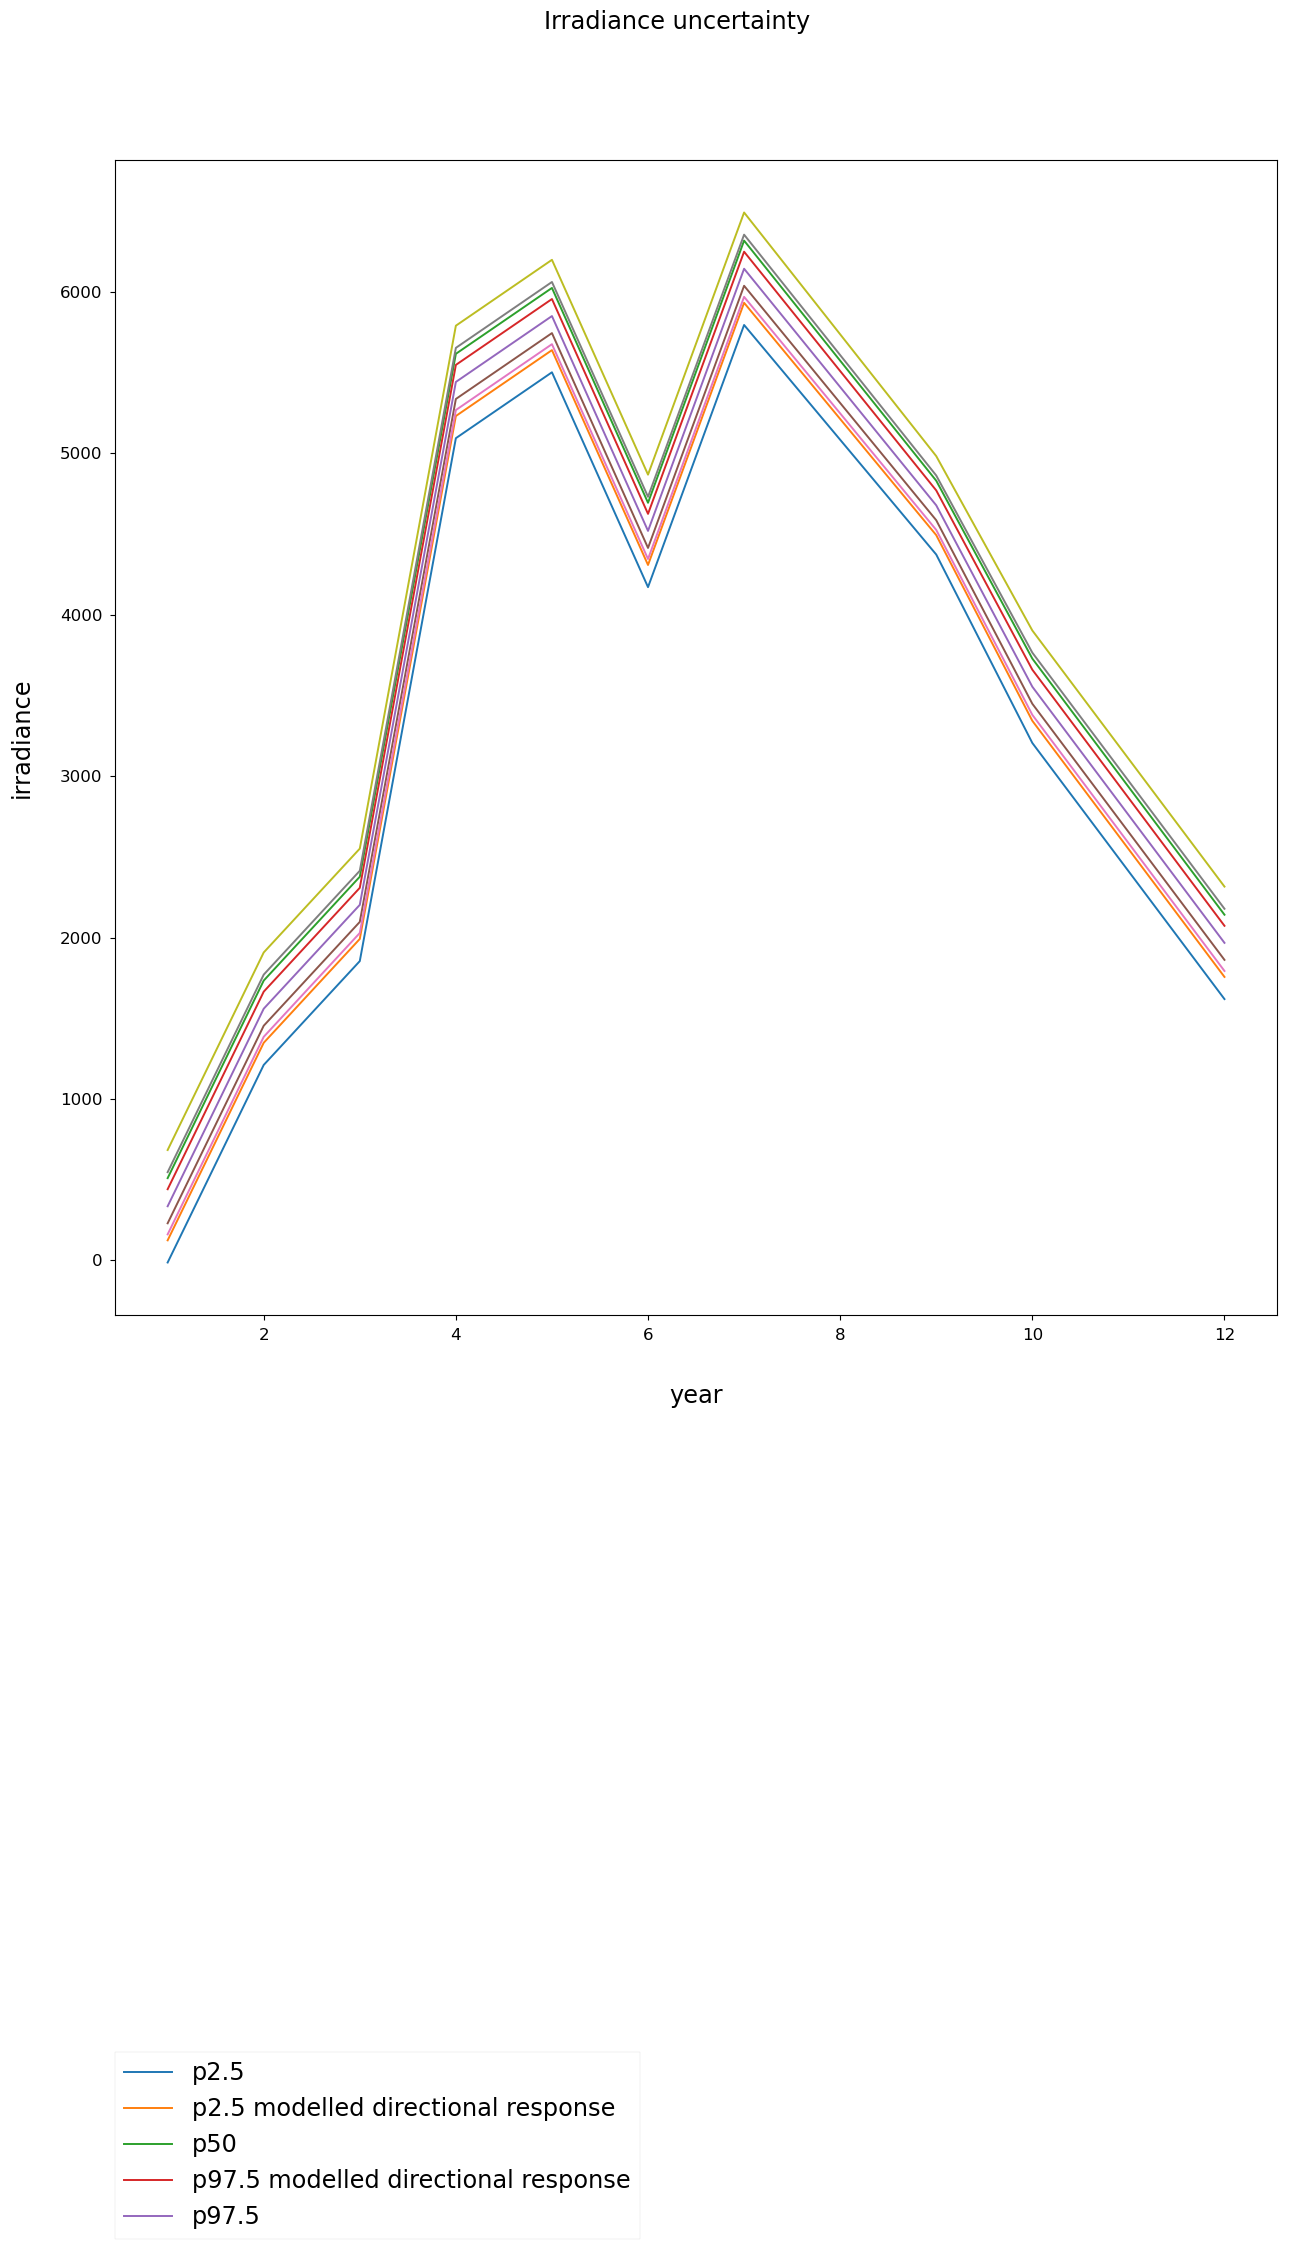

In [ ]:
#%%
fig, ax = plt.subplots()
for c in columns_grp:
    #condition on which percentiles to be showed to be imposed
    if c != "year":
        ax.plot(pvs_yearly.year, pvs_yearly.loc[:,c])

iplt.finalise_subplots(fig, ax, fig_title= "Irradiance uncertainty",
                  lgn_labels = ["p2.5", "p2.5 modelled directional response", "p50", "p97.5 modelled directional response", "p97.5"],
                       xlabel="year", ylabel="irradiance", bbox_to_anchor=(0,-0.8))
    #, bbox_to_anchor=(0,-0.1)) #, loc=0)
#, plt_prm='', bbox_to_anchor=LGN_BBOX_TO_ANCHOR, loc=LGN_LOC)

### Testing Irradiance long-term uncertainty

Sources for long-term uncertainty to be reviewed
To be checked:
- if and how sensitivity coefficient to be used
- if really percentage
- if suitable also for CREST situation, e.g. some model for Bolzano
- replacing previous sources with original paper sources if possible


G. Belluardo, M. Herz, U. Jahn, M. Richter, and D. Moser, “Evaluation of uncertainty in PV project design
 : definition of scenarios and impact on energy yield predictions,” 2017.

Müller, Björn Hardt, Laura Armbruster, Alfons Kiefer, Klaus Reise, Christian
Yield predictions for photovoltaic power plants: empirical validation, recent advances and remaining uncertainties
SOURCES PROVIDED

Table III. Estimated uncertainties and uncertainty contributions for a yield prediction of a typical crystalline
silicon PV system in a moderate (middle European) climate.

In [ ]:
yield_uncertainty = unc.Irradiance_Uncertainty(sensitivity=None)

In [ ]:
#for testing purpose using irradiance as parameter for all instead of power 

YEAR=1

INSOLATION_VARIABILITY_5Y={'uncertainty':'insolation_variability','parameter':'irradiance','distribution':'normal',
                           'shape':'symmetric','divisor':1,'unit':'%','acceptance':9}
#19/9/21 Solar resource calculated for the first year
# calculated for the entire period although maybe average could be considered
SOLAR_RESOURCE_AOI= {'uncertainty':'solar_resource_aoi','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                         'acceptance':round((pvs_yearly.loc[YEAR,"p160_aoi"]/pvs_yearly.loc[YEAR,"gpoa"] - 1)*100, 2)}

SOLAR_RESOURCE = {'uncertainty':'solar_resource','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':round((pvs_yearly.loc[YEAR,"p160"]/pvs_yearly.loc[YEAR,"gpoa"] - 1)*100, 2)}


In [ ]:

#for testing purpose using irradiance as parameter for all instead of irradiance 

# TRANSPOSITION MODEL NOT NEEDED
# Notes: it is true that long-term simulation are done with gpoa but nothing prevent to do them with POA actually

# AMBIENT_TEMPERATURE_VARIABILITY_5Y could be estimated from CREST available data

#best fitting 0.14, exemplary simulation 1, bad fitting 1;15
TEMPERATURE_EFFECT =  {'uncertainty':'temperature_effect','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':1}

# negative only, period to be checked. lowest value in accord with Nikol's thesis
# long-term not included in one year
PERFORMANCE_LOSS = {'uncertainty':'performance_loss','parameter':'irradiance','distribution':'normal',
                     'shape':'negative','divisor':1,'unit':'%',
                     'acceptance':0.5}

# low uncertainty minor issue in Lboro and experimental research system
SOILING = {'uncertainty':'soiling','parameter':'irradiance','distribution':'normal',
                     'shape':'negative','divisor':1,'unit':'%',
                     'acceptance':0.5}

# SHADING EFFECT not considered

REFLECTION_MISMATCH = {'uncertainty':'reflection_mismatch','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':0.2}

NOMINAL_POWER = {'uncertainty':'nominal_irradiance','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':0.98}

INVERTER_EFFICIENCY = {'uncertainty':'inverter_efficiency','parameter':'irradiance','distribution':'normal',
                     'shape':'symmetric','divisor':1,'unit':'%',
                     'acceptance':0.2}

# DC cabling not considered
# Power limitation not considered
# Transformer not considered
# System behaviour 

In [ ]:
yield_df = pd.DataFrame()

yield_uncertainties_df = pd.DataFrame()

yield_uncertainties = [SOLAR_RESOURCE_AOI, SOLAR_RESOURCE, TEMPERATURE_EFFECT,
                     PERFORMANCE_LOSS, SOILING, REFLECTION_MISMATCH, NOMINAL_POWER, INVERTER_EFFICIENCY]

for value in list(yield_uncertainties ):
    yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
#DEV NOTE 26/9/21 index not column used for uncertainty type
yield_uncertainties_df.index = yield_uncertainties_df.loc[:,"uncertainty"]

#showing uncertainty_df
# 6/11/21 only irradiance-dependant uncertainty provided
yield_uncertainties_df

C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  yield_uncertainties_df=yield_uncertainties_df.append(value,ignore_index=True)
C:\Users\wsfm\AppData\Local\Temp\ipykernel_14980\2683006524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future 

,uncertainty,parameter,distribution,shape,divisor,unit,acceptance
uncertainty,,,,,,,
solar_resource_aoi,solar_resource_aoi,irradiance,normal,symmetric,1,%,31.42
solar_resource,solar_resource,irradiance,normal,symmetric,1,%,51.85
temperature_effect,temperature_effect,irradiance,normal,symmetric,1,%,1.00
performance_loss,performance_loss,irradiance,normal,negative,1,%,0.50
soiling,soiling,irradiance,normal,negative,1,%,0.50
reflection_mismatch,reflection_mismatch,irradiance,normal,symmetric,1,%,0.20
nominal_irradiance,nominal_irradiance,irradiance,normal,symmetric,1,%,0.98
inverter_efficiency,inverter_efficiency,irradiance,normal,symmetric,1,%,0.20


In [ ]:
yield_uncertainty.uncertainties_df = yield_uncertainties_df

yield_uncertainty_labels_y1 = yield_uncertainties_df.uncertainty.to_list()
yield_uncertainty_labels_y1.remove("solar_resource_aoi")
yield_uncertainty_labels_y1.remove("performance_loss")

yield_uncertainty_labels_y1_aoi = yield_uncertainties_df.uncertainty.to_list()
yield_uncertainty_labels_y1_aoi.remove("solar_resource")
yield_uncertainty_labels_y1_aoi.remove("performance_loss")

In [ ]:
yield_uncertainty.sensitivity

In [ ]:
randomstate = np.random.RandomState(210829)
percentiles = [10, 50, 90]

simulations = 100
#mc not needed for calibration uncertainty since function and cofficients known

irradiance = pd.Series(pvs_yearly.loc[YEAR,"gpoa"])

deviations_mc_y1 = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=yield_uncertainty_labels_y1,
                                                                  angle_of_incidence=None)


deviations_mc_y1

c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model\source\uncertainty.py:756: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_results = exp_results.append(dict_tmp, ignore_index=True)


,10,50,90
0,-224.04223,-21.431391,161.492952


yield vs yield in reference period used in IEA-PVPS T13-12:2018

In [ ]:
years = len(pvs_slc["year"].unique())
ylabels = ["p10","p50","p90"]
pv_yield_y1 = irradiance.values[0]

pv_yield = pd.DataFrame()
pv_yield["year"] = pvs_slc["year"].unique()
pv_yield.set_index(keys="year", drop=True, inplace=True)
# DEV NOTE 26/9/21 formatting of p100 could be done

devs_y1 = {}

l = "dev_y1_"
for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
    pv_yield[l+k] = [deviations_mc_y1.loc[:,v][0]] * years
    devs_y1[k]=l+k
    #pv_yield[k] = 1 + pv_yield[l+k] / pv_yield_y1
    #pv_yield[k] = [1 + deviations_mc_y1.loc[:,v][0] / pv_yield_y1 ] * years
pv_yield

,dev_y1_p10,dev_y1_p50,dev_y1_p90
year,,,
1,-224.04223,-21.431391,161.492952
2,-224.04223,-21.431391,161.492952
3,-224.04223,-21.431391,161.492952
4,-224.04223,-21.431391,161.492952
5,-224.04223,-21.431391,161.492952
6,-224.04223,-21.431391,161.492952
7,-224.04223,-21.431391,161.492952
9,-224.04223,-21.431391,161.492952
10,-224.04223,-21.431391,161.492952


Legend: loc (0, 0), bbox_to_anchor (0, -0.2)
Final yield uncertainty.jpg saved at c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model/outputs/figures/


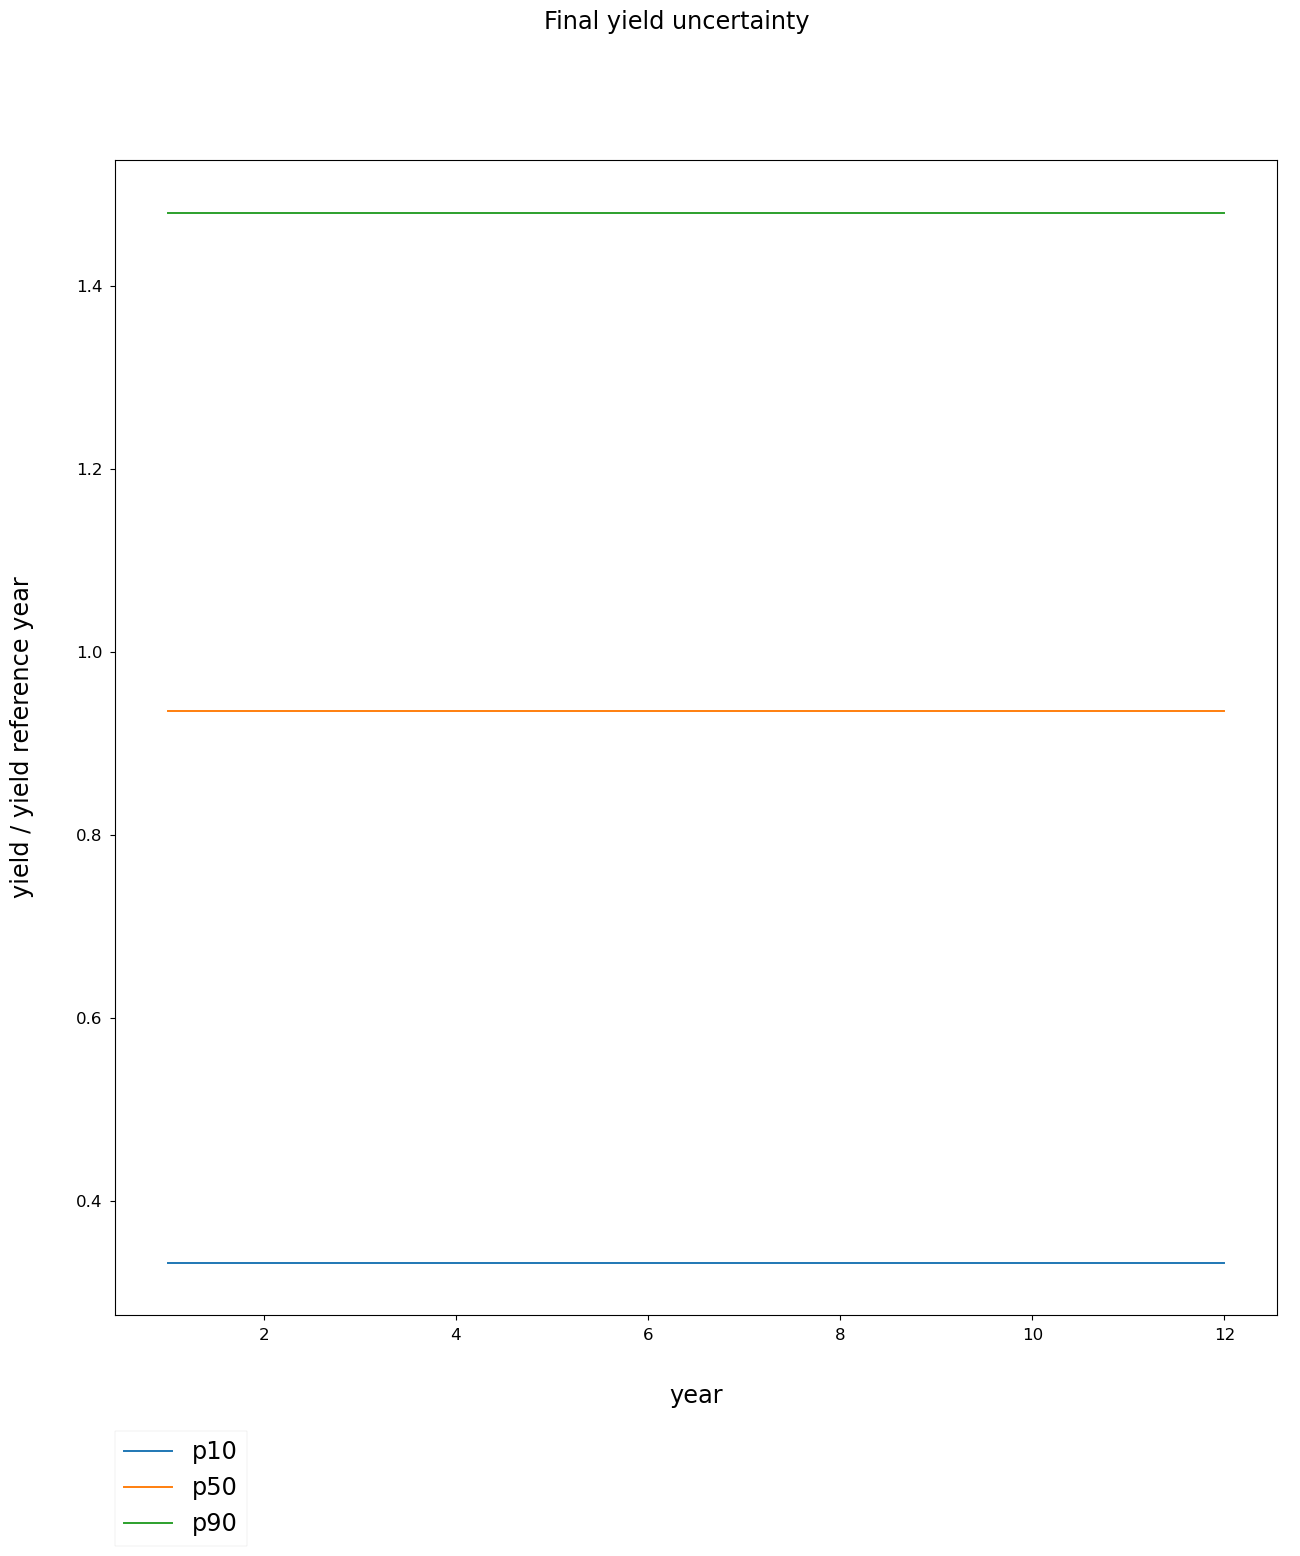

In [ ]:
# 6/11/21 add absolute irradiance on the parasite axis

fig, ax = plt.subplots()
for c in [v for v in devs_y1.values()]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield.index, 1 + pv_yield.loc[:,c] / pv_yield_y1)

iplt.finalise_subplots(fig, ax, fig_title= "Final yield uncertainty",
                  lgn_labels = ylabels,
                       xlabel="year", ylabel="yield / yield reference year", bbox_to_anchor=(0,-0.2))


In [ ]:
#long-term deviations
l = "dev_lt_"
# assing deviation first year to all years. Long-term deviation will be cumulated after
pv_yield[[l+p for p in ylabels]] = pv_yield[["dev_y1_"+p for p in ylabels]]
for y in pv_yield.index.to_list():
    deviations_mc_lt = yield_uncertainty.get_uncertainty_mc(randomstate=randomstate,
                                                                  irradiance=irradiance, coverage_factor=None,
                                                                  simulations=simulations, percentile=percentiles,
                                                                  uncertainties_labels=["performance_loss"],
                                                                  angle_of_incidence=None)
    for k,v in dict(zip(ylabels,[str(c) for c in percentiles])).items():
        # adding long-term deviation. Small contribution comparing to existing one.
        pv_yield.loc[pv_yield.index >= y,l+k] += deviations_mc_lt.loc[:,v][0]

pv_yield

c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model\source\uncertainty.py:756: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_results = exp_results.append(dict_tmp, ignore_index=True)
c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model\source\uncertainty.py:756: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_results = exp_results.append(dict_tmp, ignore_index=True)
c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model\source\uncertainty.py:756: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  exp_results = exp_results.append(dict_tmp, ignore_index=True)
c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model\

,dev_y1_p10,dev_y1_p50,dev_y1_p90,dev_lt_p10,dev_lt_p50,dev_lt_p90
year,,,,,,
1,-224.04223,-21.431391,161.492952,-226.176609,-21.245800,163.938888
2,-224.04223,-21.431391,161.492952,-227.686865,-21.115634,165.679243
3,-224.04223,-21.431391,161.492952,-229.374818,-20.831789,167.741400
4,-224.04223,-21.431391,161.492952,-231.410102,-20.290973,169.996035
5,-224.04223,-21.431391,161.492952,-233.401887,-20.428696,171.710189
6,-224.04223,-21.431391,161.492952,-235.547686,-20.261580,173.938958
7,-224.04223,-21.431391,161.492952,-237.544509,-20.213713,176.247339
9,-224.04223,-21.431391,161.492952,-239.342641,-20.260741,178.455114
10,-224.04223,-21.431391,161.492952,-241.502380,-20.309448,180.385594


Legend: loc (0, 0), bbox_to_anchor (0, -0.2)
Final yield uncertainty long-term.jpg saved at c:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\pv_module_model/outputs/figures/


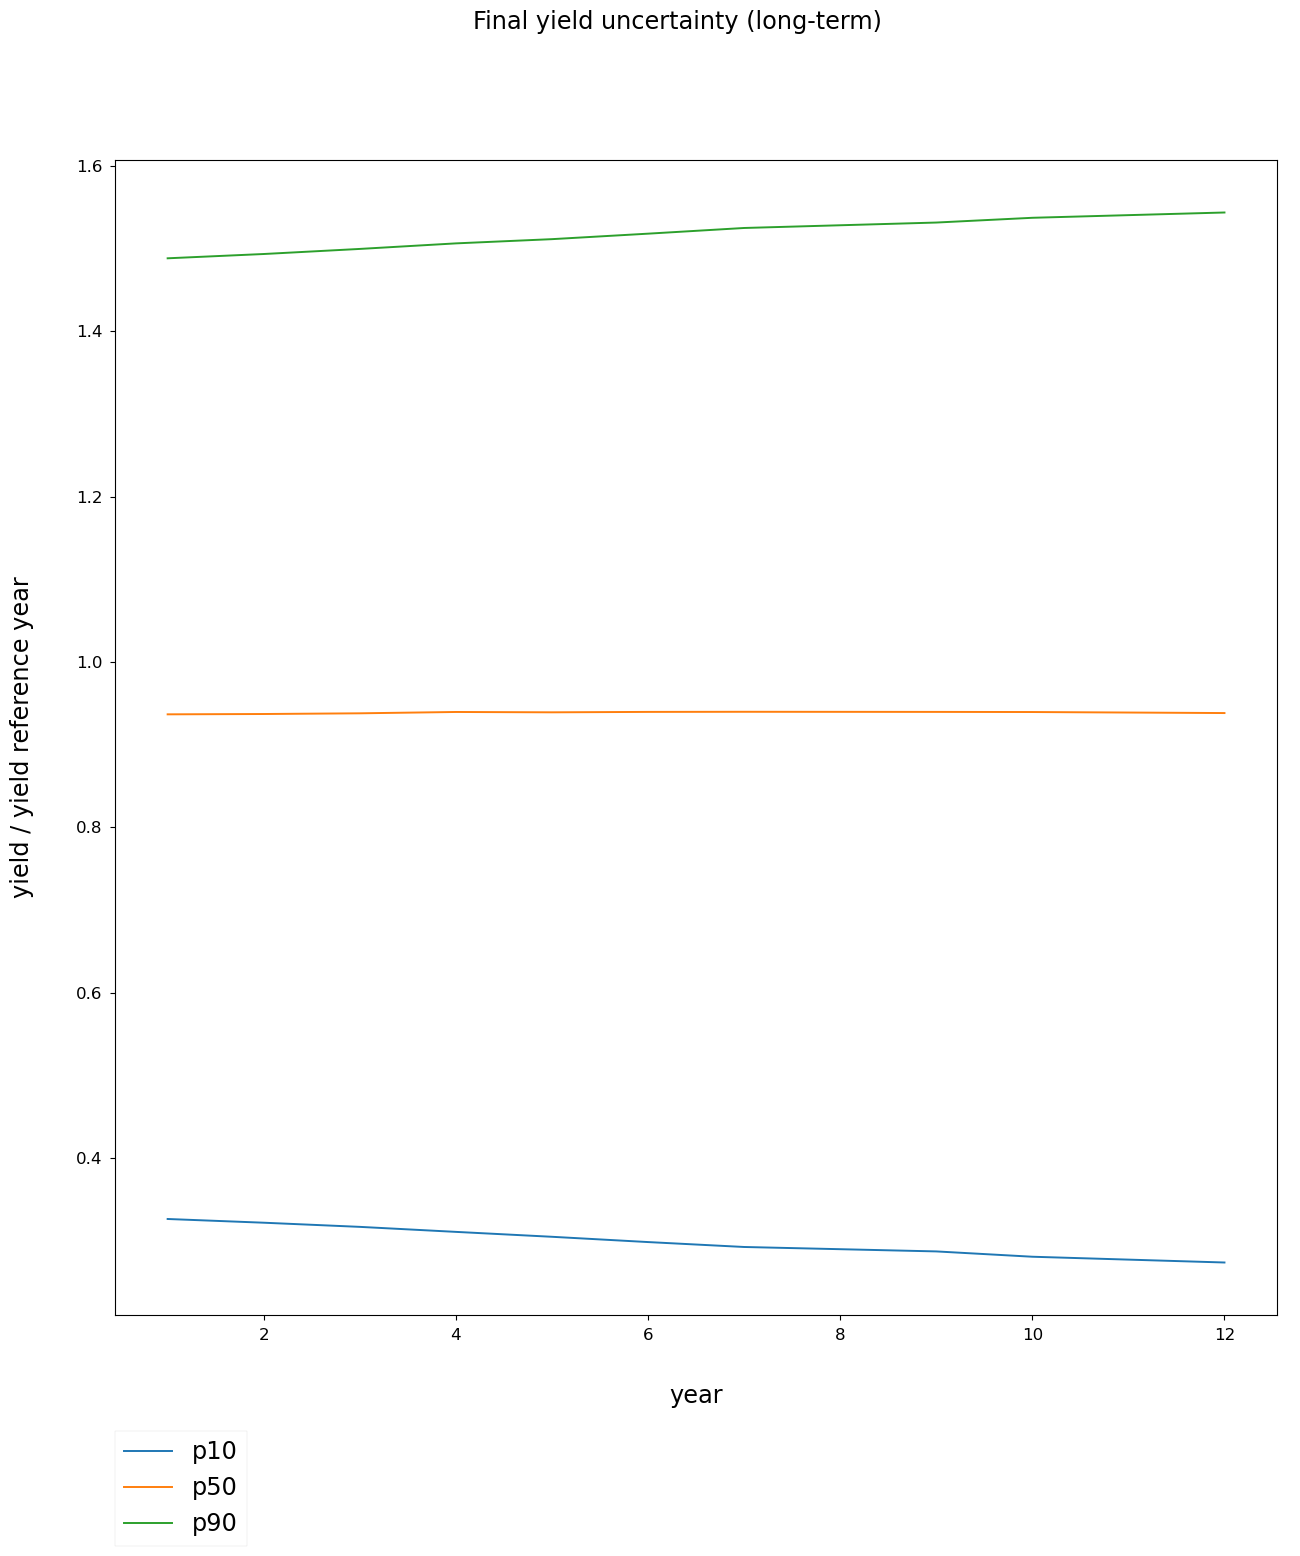

In [ ]:
fig, ax = plt.subplots()
for c in [c for c in pv_yield.columns.to_list() if l in c]:
    #condition on which percentiles to be showed to be imposed
    ax.plot(pv_yield.index, 1 + pv_yield.loc[:,c] / pv_yield_y1)

iplt.finalise_subplots(fig, ax, fig_title= "Final yield uncertainty (long-term)",
                  lgn_labels = ylabels,
                       xlabel="year", ylabel="yield / yield reference year", bbox_to_anchor=(0,-0.2))


### Intrannual variability

Could be calculate from CREST data if necessary ?

Reference approach was from (IEEE conference paper):
**G. Belluardo, M. Herz, U. Jahn, M. Richter, and D. Moser, “Evaluation of uncertainty in PV project design
 : definition of scenarios and impact on energy yield predictions,” 2017.**

Reference values from Solar Bankability report (not paper):
**Jahn, Ulrike   Moser, David Richter, Mauricio
Minimizing Technical Risks in Photovoltaic Projects Recommendations for Minimizing Technical Risks of
PV Project Development and PV Plant Operation**
For Bolzano 9% uncertainty used not clear how estimated.

Uncertainty analysis previously carried in another Solar Bankability report:
**Moser, David    Del Buono, Matteo   Bresciani, Walter   Veronese, Elisa Jahn, Ulrike    Herz, Magnus
Janknecht, Eckart   Ndrio, Erin     De Brabandere, Karel    Richter, Mauricio
Technical Risks in PV Projects
Report on Technical Risks in PV Project Development and PV Plant Operation**

**Definition of annual insolation variability**
The annual insolation variability or “year-to-year variability” is defined as the ratio of the standard deviation (σ)
to the average global horizontal irradiation (GHI) over a long-term period (typically more than 10 years)
(K. Scharmer and J. Greif, 2000), (Richter et al., 2015).
In average, the standard deviation of the yearly sums of GHI is mostly in the range of 4% to 6% as shown for example,
by (Richter et al., 2015) and (Suri et al., 2007).

Table 9 presents an overview of the variability (σ) of GHI as extracted from Meteonorm (METEOTEST Genossenschaft, 2014)
for some representative weather stations located across Europe. The 90% exceedance probability (P90 scenario) is also provided.
The σ90 in Table 9 is calculated by multiplying σ with 1.328,
i.e. the conversion factor between the standard deviation and a single-sided P90 deviation considering
a Student’s t-distribution with a sample size of 20 years (period covered by the irradiation database).

Table 9: Variability of the annual GHI for different sites in Europe (20 years)
No data for Bolzano. Method description


# Annex testing uncertainty f with gum

In [ ]:
pyrano_irr_unc = unc.Irradiance_Uncertainty( method=method+" cmp21",
                                            sensitivity=CREST_CMP11_06_SENSITIVITY,
                                            radiometer_type="pyranometer")
pyrano_unc_labels = pyrano_irr_unc.uncertainties_df.index.to_list()
# remove zero_offset_total since using its single components
pyrano_unc_labels.remove("zero_offset_total")
# removing directional since modelled separately with beam irradiance
pyrano_unc_labels.remove("directional_response")
# 13/8/23 remove alignement error since systematical functional dependency implemented only for gum and not for mc yet
pyrano_unc_labels.remove("alignment_zenith")
pyrano_unc_labels.remove("alignment_azimuth")

In [ ]:
 pyrano_irr_unc.uncertainties_df = pyrano_irr_unc.uncertainties_df.loc[pyrano_unc_labels,:]

In [ ]:
args = {
"irradiance": dfs[pvmm.pld["poa_global"]], #* np.cos(np.deg2rad(dfs["angleofincidence"])),
"temperature": None,
"azimuth": dfs["pyr_azimuth"],
"angle_of_incidence": dfs["angleofincidence"],
"coverage_factor": coverage_factor,
"uncs_mc_cffs": None,
"asymmetric_pair": asymmetric_pair,
"directional_error": False
}

In [ ]:
deviations_gum_pyrano = dfs.iloc[[0,10,300],:].apply(lambda x:
pyrano_irr_unc.get_uncertainty(
irradiance=x[pvmm.pld["poa_global"]], #* np.cos(np.deg2rad(dfs["angleofincidence"])),
temperature=None,
azimuth=x["pyr_azimuth"],
angle_of_incidence=x["angleofincidence"],
coverage_factor=coverage_factor,
uncs_mc_cffs=None,
asymmetric_pair=asymmetric_pair,
directional_error=False
), axis=1)

In [ ]:
dfs.columns

Index(['minute_trunc', 'impp_avg', 'vmpp_avg', 'temp_module1_avg',
       'g_cmp11_ppuk_avg', 't_ambient_avg', 'wind_speed_avg', 'chp_02_avg',
       'chp_02_pt100_avg', 'zenith', 'azimuth', 'angleofincidence',
       'airmassabsolute', 'pyr_azimuth', 'sapm_spectral_loss', 'pmpp'],
      dtype='object')

In [ ]:
deviations_gum_pyrano = dfs.iloc[[0,10,300],:].apply(lambda x:
pyrano_irr_unc.get_uncertainty_gum(
irradiance_total = x[pvmm.pld["poa_global"]], #* np.cos(np.deg2rad(dfs["angleofincidence"])),
diffuse_fraction = 1 - x[pvmm.pld["poa_direct"]]/x[pvmm.pld["poa_global"]],
#zenith = x["zenith"],
#azimuth = x["azimuth"],
#surface_azimuth = 180,
#surface_zenith = 34,
temperature=None
), axis=1)

In [ ]:
deviations_gum_pyrano

datetime
2018-01-01 08:56:00    7.241556
2018-01-01 09:06:00    7.244845
2018-01-01 14:04:00    9.955430
dtype: float64

In [ ]:
dfs.iloc[[0,10,300],:].loc[:,pvmm.pld["poa_global"]]

datetime
2018-01-01 08:56:00     20.229
2018-01-01 09:06:00     23.809
2018-01-01 14:04:00    393.521
Name: g_cmp11_ppuk_avg, dtype: float64

In [ ]:
deviations_gum_pyrano

datetime
2018-01-01 08:56:00    4.396969
2018-01-01 09:06:00    4.396969
2018-01-01 14:04:00    4.396969
dtype: float64

In [ ]:
irradiance = dfs[pvmm.pld["poa_global"]] #* np.cos(np.deg2rad(dfs["angleofincidence"])),
temperature = None
azimuth = dfs["pyr_azimuth"]
angle_of_incidence = dfs["angleofincidence"]
coverage_factor = coverage_factor
uncs_mc_cffs = None
asymmetric_pair = asymmetric_pair
directional_error = False

In [ ]:
self =  pyrano_irr_unc

In [ ]:


# all the elemens in the azimuth and AOI series need to be <> None to calculate deviation
"""
:param irradiance:
:param temperature:
:param azimuth:
:param angle_of_incidence:
:param coverage_factor:
:param uncs_mc_cffs:
:param test:
:param asymmetric_pair: only for GUM not needed for MC
:param directional: 
:return:
"""
#16/10/21 adding float
#26/9/21 DEV NOTES mixing both mc and not, coudl be splitted ?
#26/9/21 asymmetric_pair to be tested
#19/9/21 TBE keeping self as storage for uncertainty parameters
#29/8/21 returning deviation for mc instead of combined uncertainty should be separate
#31/8/21 alignement part in get_uncertainty_gum to be integrated
#defining starting parameters value different than changing mc
p0 = {}
# if no parameters provided at all use stored self.uncertainties_df
if uncs_mc_cffs is None:
    uncertainties_lst = self.uncertainties_df.uncertainty.to_list()
else:
    uncertainties_lst = [u for u in uncs_mc_cffs.keys()]
parameters_lst = [u for u in np.unique(self.uncertainties_df.loc[uncertainties_lst, "parameter"])]
# checking if mc parameters provided
# it is not so useful to combine mc with gum but could be eventually coded just to check effect of asymmetric
# removing temperature and directional response if provided
if np.all(temperature) is not None:
    # 16/10/21 TBC if transformation into series required
    p0["sensitivity"] = self.sensitivity * (100 + self.get_deviation_on_temperature(temperature)) / 100
    uncertainties_lst.remove("temperature_response")
else: p0["sensitivity"] = self.sensitivity
#29/8/21 possibility of calculating only when valid ?



if directional_error and ( 
(((np.all(azimuth) is not None) and (np.all(azimuth) is not np.nan)) or
    ((np.all(angle_of_incidence) is not None) or (np.all(angle_of_incidence) is not np.nan)))):
    # check if deviation not None (e.g. aoi <90 )
    # print(f"deviation_directional = self.get_deviation_on_direction AZ {azimuth} AOI{angle_of_incidence}")
    deviation_directional = self.get_deviation_on_direction(azimuth, angle_of_incidence)
    if deviation_directional is not None:
        irradiance = irradiance * (100 + deviation_directional) / 100
        # directional response different than tilt
        uncertainties_lst.remove("directional_response")
#else:
#    print("Skip directional error since not valid azimuth and/or aoi")

# initialise p as p0 for mc too
# p0 defined regardless if in self.uncertainties_df.parameter.to_list() since may be used for coefficients later
p0["irradiance"] = irradiance
# 17/10/21 test if not None
if p0["sensitivity"] is not None:  p0["voltage"] = p0["sensitivity"] * p0["irradiance"]
if uncs_mc_cffs is not None and np.all([u for u in uncs_mc_cffs.values()]) is not None:
    mc_ck = True
    #deviation functions
    f = {}
    irradiance_mc = irradiance
    # 26/9/21 TBC if proper approach
    # 24/10/21
    f["irradiance"] = lambda irr, mc_dev: irr + mc_dev
    f["voltage"] = lambda irr, mc_dev: irr + mc_dev
    # reduction (negative mc) of sensitivity -> irradiance could be higher
    f["sensitivity"] = lambda irr, mc_dev: irr * (p0["sensitivity"]) / (p0["sensitivity"]+mc_dev)
    """f["irradiance"] = lambda irr, mc_dev: irr * mc_dev
    f["voltage"] = lambda irr, mc_dev: irr * mc_dev
    f["sensitivity"] = lambda irr, mc_dev: irr / mc_dev"""

else:
    mc_ck = False
    # DEV 26/9/21 to be adapted for difference types of uncertainties
    # only if not mc:
    # calculate sensitivity coefficient for gum
    # c also needed to check which parameter to be considered for mc
    c = {}
    # 29/8/21 in ISO voltage already provided as irradiance [Wm-2] acceptance
    # coefficients only for GUM
    if isinstance(irradiance, pd.Series):
        if "voltage" in parameters_lst: c["voltage"] = p0["irradiance"].apply(lambda x: 1 / p0["sensitivity"])
        if "sensitivity" in parameters_lst: c["sensitivity"] = p0["voltage"].apply(lambda x: - x / (p0["sensitivity"] ** 2))
        if "irradiance" in parameters_lst: c["irradiance"] = p0["irradiance"].apply(lambda x: 1)
    else:
        if "voltage" in parameters_lst: c["voltage"] = 1 / p0["sensitivity"]
        if "sensitivity" in parameters_lst: c["sensitivity"] = -(p0["voltage"]) / (p0["sensitivity"] ** 2)
        if "irradiance" in parameters_lst: c["irradiance"] = 1

# defining parameters
comb_stnd_uncr = 0
c_s_u_positive_only = 0
c_s_u_negative_only = 0
for u in uncertainties_lst:
    parameter, acceptance, unit, divisor, shape = \
        self.uncertainties_df.loc[u,["parameter","acceptance","unit","divisor","shape"]]
    #calculate only if parameter dependency is defined
    try:
        if unit == "%": acceptance = p0[parameter] * acceptance / 100
    except KeyError:
        print(f"Missing {parameter} requested for {u}")
        raise KeyError
    # if using mc 
    if mc_ck and parameter in [k for k in f.keys()]:
        # transforming in % if not already
        #if unit != "%": acceptance = acceptance / p0[parameter] * 100
        #24/10/21 regardless of distribution still sum (if negative -> negative already)
        mc_dev = uncs_mc_cffs[u] * acceptance
        """if shape == "symmetric":
            #mc_dev = (1 + uncs_mc_cffs[u] * acceptance / 100)
            mc_dev = uncs_mc_cffs[u] * acceptance
        elif shape == "negative":
            #mc_dev = (1 - uncs_mc_cffs[u] * acceptance / 100)
        
        elif shape == "positive":
            #mc_dev = (1 + uncs_mc_cffs[u] * acceptance / 100)"""

        if test:
            self.uncertainties_df.loc[u, "mc"] = uncs_mc_cffs[u]
            self.uncertainties_df.loc[u, "irr_dev"] = mc_dev
        irradiance_mc = f[parameter](irradiance_mc, mc_dev)
        """if parameter == "irradiance" or parameter == "voltage":
            irradiance_mc = irradiance_mc * mc_dev
        elif parameter == "sensitivity":
            irradiance_mc = irradiance_mc / mc_dev"""
    elif mc_ck == False and parameter in [k for k in c.keys()]:
        # for GUM percentage transformed into absolute due to different coefficient
        if unit == "%": acceptance = p0[parameter] * acceptance / 100
        acceptance = acceptance / divisor
        # DEALING WITH ASYMMETRICAL DISTRIBUTION
        # "Uncertainty evaluation of measurements with pyranometers and pyrheliometers"
        # Konings, Jörgen   Habte, Aron
        # but other approaches could be possible
        # 19/9/21 not considering that symmetric should be only in one direction
        if shape != "symmetric":
            acceptance = acceptance / 2
        if asymmetric_pair:
            if acceptance > 0: c_s_u_positive_only += c[parameter] ** 2 * (acceptance ** 2)
            elif acceptance < 0: c_s_u_negative_only += c[parameter] ** 2 * (acceptance ** 2)
        elif asymmetric_pair == False:
            comb_stnd_uncr += c[parameter] ** 2 * (acceptance ** 2)
        #if test: print(f"{}")
        # calculate combined standard uncertainty
if mc_ck:
    # 24/10/21
    uncr = irradiance_mc - irradiance
elif mc_ck == False:
    if asymmetric_pair:
        uncr = ((comb_stnd_uncr+c_s_u_negative_only)** 0.5 * coverage_factor,
                (comb_stnd_uncr+c_s_u_positive_only)** 0.5 * coverage_factor)
    elif asymmetric_pair == False:
        # keep different steps for better understanding of parameters involved
        comb_stnd_uncr = comb_stnd_uncr ** 0.5
        # calculate combined expanded uncertainty
        exp_uncr = comb_stnd_uncr * coverage_factor
        uncr = exp_uncr

In [ ]:
comb_stnd_uncr

datetime
2018-01-01 08:56:00    4.396969
2018-01-01 08:57:00    4.396969
2018-01-01 08:58:00    4.396969
2018-01-01 08:59:00    4.396969
2018-01-01 09:00:00    4.396969
                         ...   
2018-12-31 15:13:00    4.396969
2018-12-31 15:14:00    4.396969
2018-12-31 15:15:00    4.396969
2018-12-31 15:16:00    4.396969
2018-12-31 15:17:00    4.396969
Name: g_cmp11_ppuk_avg, Length: 197818, dtype: float64

In [ ]:
 #defining starting parameters value different than changing mc
p0 = {}

# 14/8/23 Annex various testings: effective_irradiance, mp

In [ ]:
# test effective irradiance
test = False
if test:
    columns = ["BeamTrp", "DifITrp", "CircTrp", "am_abs", "AngInc", "sapm_effective_irradiance"]
    values = [948.8800,	30.0690,	136.6200,	1.664707,	18.801,	1124.901832]
    t = pd.Series(dict(zip(columns,values))).to_frame().T
    t.rename(columns=dict(zip(
    columns,["chp_02_avg", "DifITrp", "CircTrp", "airmassabsolute", "angleofincidence", "g_cmp11_ppuk_avg"]
    )), inplace=True)
    t["angleofincidence"] = 90
    t["poa_diffuse"] = t["DifITrp"] + t["CircTrp"]
    pvmm.add_effective_irradiance(t)

In [ ]:
ps_prms ={
'alpha_sc': 0.0029, #=
 'I_L_ref': 8.49, #=
 'I_o_ref': 4.0000000000000004e-11, #=
 'R_s': 0.3, #=
 'R_sh_ref': 300, #=
 'gamma_ref': module["gamma_ref"], #-0.45,
 'cells_in_series': 60,
 'EgRef': 1.12,
 'irrad_ref': 1000,
 'temp_ref': 25
}

In [ ]:
# t.drop(columns=["i_mp","v_mp"], inplace=True)
t = get_iv(t, ps_prms, calcparams="desoto", calcmpp="singlediode", method="lambertw", ivcurve_pnts=400)
#t[['g_cmp11_ppuk_avg', 'chp_02_avg', 'effective_irradiance', "angleofincidence", 'temp_module1_avg',
#     'impp_avg','i_mp','vmpp_avg','v_mp']]   
t[['g_cmp11_ppuk_avg', 'chp_02_avg', 'effective_irradiance', "angleofincidence", 'temp_module1_avg',
     'impp_avg','i_mp','vmpp_avg','v_mp']]  

In [ ]:
t = dfs.copy(deep=True)
#t.replace(0.000000,1000, inplace=True)
t.replace(7.254091,25, inplace=True)
t["effective_irradiance"] = 1000
t = pvmm.add_mpp(t)
t[['g_cmp11_ppuk_avg', 'chp_02_avg', 'effective_irradiance', "angleofincidence", 'temp_module1_avg',
     'impp_avg','i_mp','vmpp_avg','v_mp']]
#pvmm.add_effective_irradiance(t)

In [ ]:
ps_prms_clmns = ['alpha_sc', 'gamma_ref', 'mu_gamma', 'I_L_ref', 'I_o_ref', 'R_sh_ref', 'R_sh_0', 'R_s', 'cells_in_series', 'R_sh_exp', 'EgRef', 'irrad_ref', 'temp_ref']
ps_prms = {k:v for k,v in pvmm.module.items() if k in ps_prms_clmns}
for k, v in dict(zip(
    ['cells_in_series', 'EgRef', 'irrad_ref', 'temp_ref',"gamma_ref"],
    [pvmm.module["N_s"], pvmm.EgRef, pvmm.irrad_ref, pvmm.temp_ref,pvmm.module["gamma_r"]]
    )).items():
    ps_prms[k] = v
t.drop(columns=[c for c in [
    "i_sc","v_oc","i_mp","v_mp","p_mp","i_x","i_xx","i","v",
    "photocurrent","saturation_current","resistance_series","resistance_shunt","nNsVth"
    ] if c in t.columns.to_list()],
inplace=True)
ps_prms

In [ ]:
#slightly adaptated get_iv

def get_iv(df:pd.DataFrame, ps_prms:dict, calcparams="desoto", calcmpp="singlediode", method="lambertw", ivcurve_pnts=400) -> pd.DataFrame:
    """
    wrap-up function
    :param df:
    :param x: dataframe dictionary
    :param ps_prms: parameters dictionary 
    :param calcparams: "desoto" or "pvsyst"
    :param calcmp: "singlediode", "bishop88"
    :param method: 'lambertw' #, 'newton', or 'brentq'
    :param ivcurve_pnts: 
    :return: df with additional columns (see below). i & v as array for each point.
    """ 
    
    # using the ones from pvsyst instead of pvlib
    temp_cell =  "temp_module1_avg" #"TArray" 
    effective_irradiance = "effective_irradiance" #"GlobEff"
    # no need to order
    clms_sd = ["photocurrent","saturation_current","resistance_series","resistance_shunt","nNsVth"]
    clms = ["i_sc","v_oc","i_mp","v_mp","p_mp","i_x","i_xx"]
    # 29/3/23 not sorted if single method ?!
    if ivcurve_pnts > 0: clms = clms + ["v","i"]
    dEgdT = - 0.0002677
    k_Boltzmann =  1.381 / (10 ** 23)
    q_electron = 1.602 / (10 ** 19)

    if calcparams == "desoto":
        df[clms_sd] = df.apply(
        lambda x:                 
        pvlib.pvsystem.calcparams_desoto(
        effective_irradiance = x[effective_irradiance], 
        temp_cell = x[temp_cell], 
        alpha_sc = ps_prms["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
        a_ref =  ps_prms["gamma_ref"] * ps_prms["cells_in_series"] * k_Boltzmann * 298.16 / q_electron,
        # The product of the usual diode ideality factor (n, unitless), number of cells in series (Ns), and cell thermal voltage at reference conditions, in units of V        
        # {\displaystyle V_{\text{T}}=kT/q,} the thermal voltage.
        # gamma_ref = ps_prms["gamma_ref"], #The diode ideality factor
        # mu_gamma = ps_prms["mu_gamma"], #The temperature coefficient for the diode ideality factor, 1/K
        I_L_ref = ps_prms["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
        I_o_ref = ps_prms["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
        R_sh_ref = ps_prms["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
        # R_sh_0 = ps_prms["R_sh_0"], #The shunt resistance at zero irradiance conditions, in ohms.
        R_s = ps_prms["R_s"], #The series resistance at reference conditions, in ohms.
        # cells_in_series = ps_prms["cells_in_series"], #The number of cells connected in series.
        #R_sh_exp=ps_prms["R_sh_exp"], #The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
        dEgdT= dEgdT, #The temperature dependence of the energy bandgap at reference conditions in units of 1/K
        EgRef=ps_prms["EgRef"], #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
        irrad_ref=ps_prms["irrad_ref"], # Reference irradiance in W/m^2.
        temp_ref=ps_prms["temp_ref"] # Reference cell temperature in C.
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms_sd,[np.nan]*len(clms_sd)))), 
        axis=1, result_type='expand')

    # version 0.93, PVsyst v6 model
    elif calcparams == "pvsyst":
        df[clms_sd] = df.apply(lambda x:                 
        pvlib.pvsystem.calcparams_pvsyst(
        effective_irradiance = x[effective_irradiance], 
        temp_cell = x[temp_cell], 
        alpha_sc = ps_prms["alpha_sc"], #The short-circuit current temperature coefficient of the module in units of A/C.
        gamma_ref = ps_prms["gamma_ref"], #The diode ideality factor
        mu_gamma = ps_prms["mu_gamma"], #The temperature coefficient for the diode ideality factor, 1/K
        I_L_ref = ps_prms["I_L_ref"], #The light-generated current (or photocurrent) at reference conditions, in amperes.
        I_o_ref = ps_prms["I_o_ref"], #The dark or diode reverse saturation current at reference conditions, in amperes.
        R_sh_ref = ps_prms["R_sh_ref"], #The shunt resistance at reference conditions, in ohms.
        R_sh_0 = ps_prms["R_sh_0"], #The shunt resistance at zero irradiance conditions, in ohms.
        R_s = ps_prms["R_s"], #The series resistance at reference conditions, in ohms.
        cells_in_series = ps_prms["cells_in_series"], #The number of cells connected in series.
        R_sh_exp=ps_prms["R_sh_exp"], #The exponent in the equation for shunt resistance, unitless. Defaults to 5.5.
        EgRef=ps_prms["EgRef"], #The energy bandgap at reference temperature in units of eV. 1.121 eV for crystalline silicon. EgRef must be >0.
        irrad_ref=ps_prms["irrad_ref"], # Reference irradiance in W/m^2.
        temp_ref=ps_prms["temp_ref"] # Reference cell temperature in C.
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms_sd,[np.nan]*len(clms_sd)))), 
        axis=1, result_type='expand')

    
    if calcmpp == "singlediode":
        df[clms] = df.apply(lambda x:                 
        pvlib.pvsystem.singlediode(
        photocurrent = x["photocurrent"],
        saturation_current = x["saturation_current"],
        resistance_series = x["resistance_series"],
        resistance_shunt = x["resistance_shunt"],
        nNsVth = x["nNsVth"], # k_Boltzmann * x[temp_cell] / q_electron
        ivcurve_pnts = ivcurve_pnts,
        method = method
        ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms,[np.nan]*len(clms))))
        , axis=1, result_type='expand')
        # not clear why array returned
        df["i_mp"]=df["i_mp"].apply(float)
        df["v_mp"]=df["v_mp"].apply(float)

    # check bishop88 seems the same as single diode
    elif calcmpp == " bishop88":
        # Explicit calculation of points on the IV curve described by the single diode equation.
        clms = ["i_mp","v_mp","p_mp"]
        m = method
        df[clms] =df.apply(lambda x:                 
        pvlib.singlediode.bishop88_mpp(
        photocurrent = x["photocurrent"],
        saturation_current = x["saturation_current"],
        resistance_series = x["resistance_series"],
        resistance_shunt = x["resistance_shunt"],
        nNsVth = x["nNsVth"], # k_Boltzmann * x[temp_cell] / q_electron
        breakdown_factor=0., 
        breakdown_voltage=-5.5,
        breakdown_exp=3.28, 
         ) if x[effective_irradiance] != 0 else
        pd.Series(dict(zip(clms,[np.nan]*len(clms))))
        , axis=1, result_type='expand')
        # 19/3/23 value error maybe due to returning variable names, renaming after
        # unecessary same results regardless of the method
        # df.rename(columns=dict(zip(clms,[c+"_bs_"+m[0] for c in clms])), inplace=True)

    return df